In [1]:
# UOC
# Grado de Ingeniería Informática
# Inteligencia Artificial
# TFG - Aplicación de Técnicas de Explicabilidad (XAI) y Cuantificación de Incertidumbre (UQ) en la Predicción del Síndrome Metabólico mediante Aprendizaje Automático
# Xema Belmonte Marín

# Preparación de los datos y tarea de clasificación

Después de explorar los datos, en este cuaderno se entrenarán varios modelos supervisados de aprendizaje automático, teniendo como objetivo una tarea de clasificación binaria. Comenzaremos seleccionando las muestras de entrenamiento, validación, calibración y prueba. A continuación, se realizará el preprocesado de los datos y se entrenarán y validarán los modelos seleccionados, estableciendo para ello el umbral de decisión. Por último, de entre todos los modelos evualuados, se seleccionará el que consideramos que desempeña mejor la tarea de clasificación.

## Librerías y funciones

### Import libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn: preparación de los datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score

# Scikit-learn: modelos de aprendizaje automático
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Modelos de gradient boosting
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Scikit-learn:: evaluación
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TunedThresholdClassifierCV

%matplotlib inline

### Funciones

In [3]:
# Opciones generales

# Desactivar warnings
warnings.filterwarnings("ignore")

# Tamaño de letra en los gráficos
font = {'size': 12}
plt.rc('font', **font)

# Mostramos 3 decimales en las tablas
pd.options.display.float_format = '{:.3f}'.format

# Definimos la métrica a optimizar
METRIC_NAME = "F1-score"
metric = make_scorer(f1_score, pos_label=1)

In [4]:
def load_and_info(file_path):
    """
    Cargamos el fichero CSV y mostramos información sobre valores ausentes, únicos, tipo de datos y valores
    """
    df = pd.read_csv(file_path)
    
    info = []
    for col in df.columns:
        data_type = str(df[col].dtype)
        missing = np.sum(pd.isna(df[col]))
        unique = df[col].nunique()
        
        # Obtenemos las categorías para variables categoricas y valores aleatorios en las numéricas
        if data_type == 'object':
            sample = df[col].dropna().unique().tolist()  # Valores únicos para las categóricas
        else:
            sample = df[col].dropna().unique()[:5].tolist()  # Los primeros 5 valores únicos para las numéricas
        
        info.append([col, data_type, missing, unique, sample])
    
    info_df = pd.DataFrame(info)
    info_df.columns = ['Column', 'Dtype', 'Missing', 'Unique', 'Sample values']
    
    # Mostramos las columnas, con información sobre valores ausentes, únicos y tipo de datos
    display(info_df)
    print("\nEl juego de datos contiene {} variables y {} observaciones, de las cuales {} son duplicadas.".format(df.shape[1], df.shape[0], len(df) - df.duplicated().count()))

    # Devolvemos el dataframe para su uso
    return df

In [5]:
def summarize_training(grid, metric_name=METRIC_NAME):
    """
    Imprime los resultados del entrenamiento con el objeto GridSearchCV pasado y
    devuelve el mejor modelo
    """
    # Imprime un resumen de los resultados
    print(f'Best Mean {metric_name}: %.3f' % grid.best_score_)
    print('Standard Deviation:', grid.cv_results_['std_test_score'][grid.best_index_].round(3))
    print('Best Parameters:', grid.best_params_)
    
    # Devuelve el mejor resultado
    return grid.best_estimator_

In [6]:
def tune_and_plot_threshold(model, X_val, y_val, num_thresholds=23):
    """
    Muestra un gráfico con las métricas de la evaluación del modelo con el set X_val por umbral de decisión
    Imprime en la leyenda además el umbral óptimo para la métrica elegida y el valor de ROC AUC
    """
    # Usamos TunedThresholdClassifierCV para encontrar el umbral de decisión óptimo para la métrica
    # (The option cv="prefit" should only be used when the provided classifier was already trained,
    # and you just want to find the best decision threshold using a new validation set)
    tuned_clf = TunedThresholdClassifierCV(model, cv="prefit", refit=False, scoring=metric)
    tuned_clf.fit(X_val, y_val)
    best_threshold = tuned_clf.best_threshold_
    best_score = tuned_clf.best_score_
    
    # Calculamos las métricas para diferentes umbrales del modelo pasado en el set de validación
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    thresholds = np.linspace(0, 1, num_thresholds)
    metrics = []
    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)
        acc = accuracy_score(y_val, y_pred)
        pre = precision_score(y_val, y_pred, zero_division=0)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        metrics.append((t, acc, pre, rec, f1))
    
    columns = ['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-score']
    df_metrics = pd.DataFrame(metrics, columns=columns)

    # Visualizamos las métricas para los diferentes umbrales
    fig = plt.subplots(figsize=(12, 6))    
    palette = ['#009E73', '#076FA1', '#2FC1D3', '#E69F00']

    # Líneas con puntos
    # (zorder to have dots be on top of the lines)
    for col, color in zip([col for col in columns if col != 'Threshold'], palette):
        plt.plot(df_metrics['Threshold'], df_metrics[col], color=color, lw=2, label=col)
        plt.scatter(df_metrics['Threshold'], df_metrics[col], fc=color, s=50, lw=1.5, ec="white", zorder=12)

    # x-axis ticks de 0 a 1 en incrementos de 0.1
    plt.xticks(np.arange(0, 1.1, 0.1))

    # Marcamos el mejor umbral para la métrica elegida
    plt.plot(best_threshold, best_score, marker=3, markersize=5, color="#D55E00", label=f"Optimal F1 Threshold = {best_threshold:.3f}")
    # Marcamos el valor ROC AUC (dummy) para incluirlo en la leyenda
    plt.plot([], [], ' ', label=f'ROC AUC: {roc_auc:.3f}')
    
    plt.legend(loc='lower center', ncol=3)
    plt.title("Métricas de rendimiento del modelo por umbral de decisión")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.tight_layout(pad=1)
    plt.show()

    return df_metrics, best_threshold

In [7]:
def train_val_metrics(model, X_train, y_train, X_val, y_val, threshold):
    """
    Imprime una tabla con las métricas de los sets de entrenamiento y validación para el modelo pasado y
    teniendo en cuenta el umbral de decisión. Devuelve un dataframe con las métricas del set de validación
    """
    y_pred_train = model.predict_proba(X_train)[:, 1]
    y_pred_val = model.predict_proba(X_val)[:, 1]

    # Calculamos las métricas para el set de entrenamiento y de validacón
    metrics = {
        'Metric': ['Accuracy', 'F1-score', 'Recall', 'Precision', 'ROC AUC'],
        'Training Set': [
            accuracy_score(y_train, y_pred_train >= threshold), 
            f1_score(y_train, y_pred_train >= threshold),
            recall_score(y_train, y_pred_train >= threshold),
            precision_score(y_train, y_pred_train >= threshold, zero_division=0),
            roc_auc_score(y_train, y_pred_train)
        ],
        'Validation Set': [
            accuracy_score(y_val, y_pred_val >= threshold), 
            f1_score(y_val, y_pred_val >= threshold),
            recall_score(y_val, y_pred_val >= threshold),
            precision_score(y_val, y_pred_val >= threshold, zero_division=0),
            roc_auc_score(y_val, y_pred_val)
        ]
    }
    
    # Mostramos tabla con los valores de las métricas
    train_val_metrics = pd.DataFrame(metrics).round(3)
    display(train_val_metrics.style.hide(axis="index"))
    
    # Devolvemos solo el dataframe con el set de validación
    val_metrics = train_val_metrics.drop(columns=["Training Set"])
    
    return val_metrics

## Preparación de los datos

Cargamos el juego de datos que habíamos explorado en el cuaderno anterior. Recordamos que contiene datos demográficos y clínicos de personas etiquetadas con el diagnóstico de síndrome metabólico.

In [8]:
df = load_and_info('metabolic_syndrome_clean.csv')

,Column,Dtype,Missing,Unique,Sample values
0,Age,int64,0,61,"[22, 44, 21, 43, 51]"
1,Sex,object,0,2,"[Male, Female]"
2,Marital,object,0,6,"[Single, Married, Widowed, Unknown, Separated,..."
3,Income,float64,116,14,"[8200.0, 4500.0, 800.0, 2000.0, 300.0]"
4,Race,object,0,6,"[White, Asian, Black, MexAmerican, Hispanic, O..."
5,WaistCirc,float64,64,635,"[81.0, 80.1, 69.6, 120.4, 81.1]"
6,BMI,float64,5,322,"[23.3, 23.2, 20.1, 33.3, 28.5]"
7,UrAlbCr,float64,0,1377,"[3.88, 8.55, 5.07, 5.22, 8.13]"
8,UricAcid,float64,0,88,"[4.9, 4.5, 5.4, 5.0, 4.8]"
9,BloodGlucose,int64,0,187,"[92, 82, 107, 104, 95]"



El juego de datos contiene 13 variables y 2380 observaciones, de las cuales 0 son duplicadas.


### División en las muestras de entrenamiento, validación, calibración y prueba

Decidimos por una división 75-25, especificando el argumento `stratify`, que controla que la distribución de la variable objetivo sea la misma en todos los conjuntos. Para poder cuantificar la incertidumbre en un próximo Notebook, debemos reservar unos datos para poder calibrar el modelo, con lo que haremos una segunda partición del *set* de prueba.

In [9]:
# Construcción de los conjuntos de entrenamiento, validación, calibración y de prueba
X = df.drop('MetabolicSyndrome', axis=1)
y = df['MetabolicSyndrome']

# Separamos entrenamiento de prueba, 75-25
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.25, random_state=23, stratify=y)

# Separamos el set de entrenamiento nuevamente para obtener el de validación
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=23, stratify=y_train_full)

# Separamos el set de prueba nuevamente para obtener el de calibración, el 20% del 25%, es decir 20/25=0.8
X_test, X_cal, y_test, y_cal = train_test_split(X_test_full, y_test_full, test_size=0.8, random_state=23, stratify=y_test_full)

Comprobemos visualmente las distribuciones de estos conjuntos:

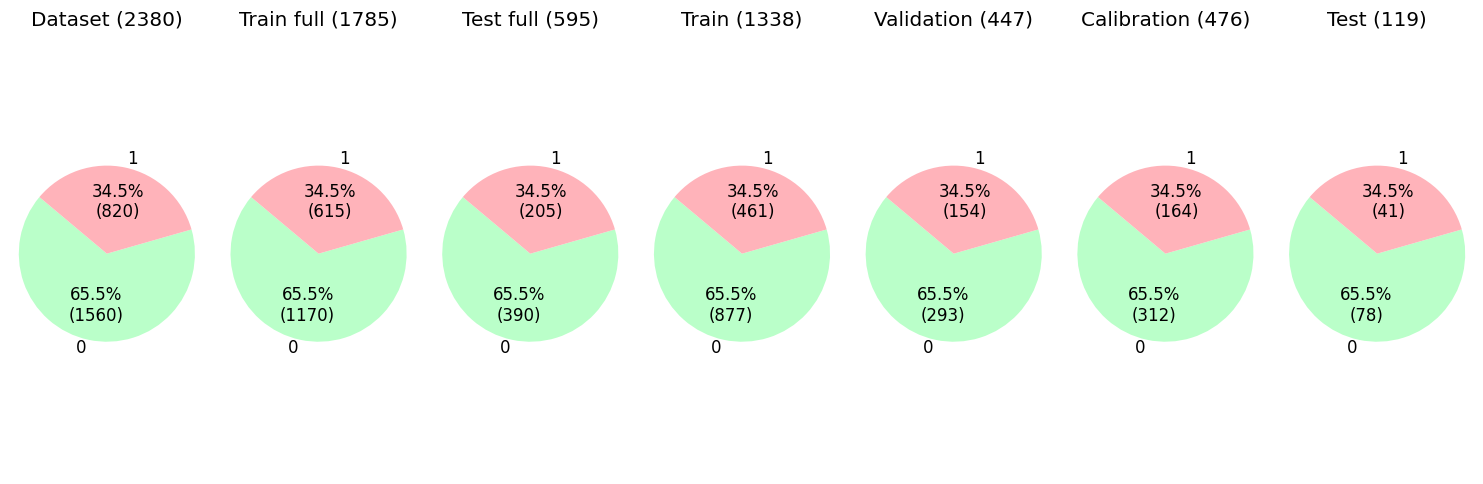

In [10]:
# Distribuciones de la clase en los distintos conjuntos
datasets = [df['MetabolicSyndrome'], y_train_full, y_test_full, y_train, y_val, y_cal, y_test]
titles = ["Dataset", "Train full", "Test full", "Train", "Validation", "Calibration", "Test"]

fig, axs = plt.subplots(1, 7, figsize=(15, 5))
for i in range(len(datasets)):
    class_counts = datasets[i].value_counts()
    ax = plt.subplot(1, 7, i+1)
    wedges, _, autotexts = plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=['#BAFFC9', '#FFB3BA'])
    ax.set_title(titles[i] + " (" + str(len(datasets[i])) + ")")
    plt.axis("equal")
    
    # Añadimos número de ejemplos junto con el porcentaje por clase
    for autotext, count in zip(autotexts, class_counts):
        autotext.set_text(f"{autotext.get_text()}\n({count})")

plt.tight_layout()
plt.show()

Verificamos pues primero que el conjunto total de entramiento corresponde al 75% (1785) de las observaciones del juego de datos (2380), y el de prueba es el 25% restante (595). Este porcentaje se mantiene en el de validación, correspondiendo al 25% de *train full*. Para el *set* de calibración reservamos el 20% (476) del conjunto de datos, eso deja el 5% restante para el de prueba (119). También comprobamos que la proporción de la variable objetivo después de la extracción aleatoria de los subconjuntos se mantiene con respecto a la del *dataset* original: la clase negativa corresponde siempre al 65,5%. 

### Codificación de las variables categóricas

In [11]:
# Listas con los nombres de las columnas categóricas
categorical = df.select_dtypes(exclude ='number').columns.tolist()

Utilizaremos variables *dummy*, que toman valores binarios, añadiendo una nueva característica (una nueva columna en el *dataframe*) para cada posible valor de la variable categórica. Es decir, lo que se conoce como codificación *one-hot*.

In [12]:
# OneHotEncoder para codificar en variables binarias y devolver un array
encoder = OneHotEncoder(sparse_output=False)

# Configuramos un transformer para devolver un dataframe y evitar las columnas numéricas
# No es necesario añadir prefijos a las columnas, ya que serán unicas
ohe = ColumnTransformer(
    transformers=[('ohe', encoder, categorical),],
    remainder='passthrough',                       # keep any other columns unchanged
    verbose_feature_names_out=False
)
ohe.set_output(transform="pandas")

ohe.fit(X_train)
X_train_processed = ohe.transform(X_train)

In [13]:
# Filtramos las columnas que han sido codificadas, esto es, contienen _ en el nombre
encoded_cols = [col for col in X_train_processed.columns if "_" in col]

display(X_train_processed[encoded_cols])

,Sex_Female,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
2284,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
801,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
624,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
543,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1173,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1233,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
840,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
811,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000


Podemos comprobar que se han codificado los dos valores únicos de la variable *Sex*, así como los 6 de cada una del resto de variables categóricas, *Marital* y *Race*. También se ha introducido colinealidad, ya que la variable *Sex* ha dado lugar a dos columnas, *Sex_Female* y *Sex_Male*, que están totalmente correlacionadas:

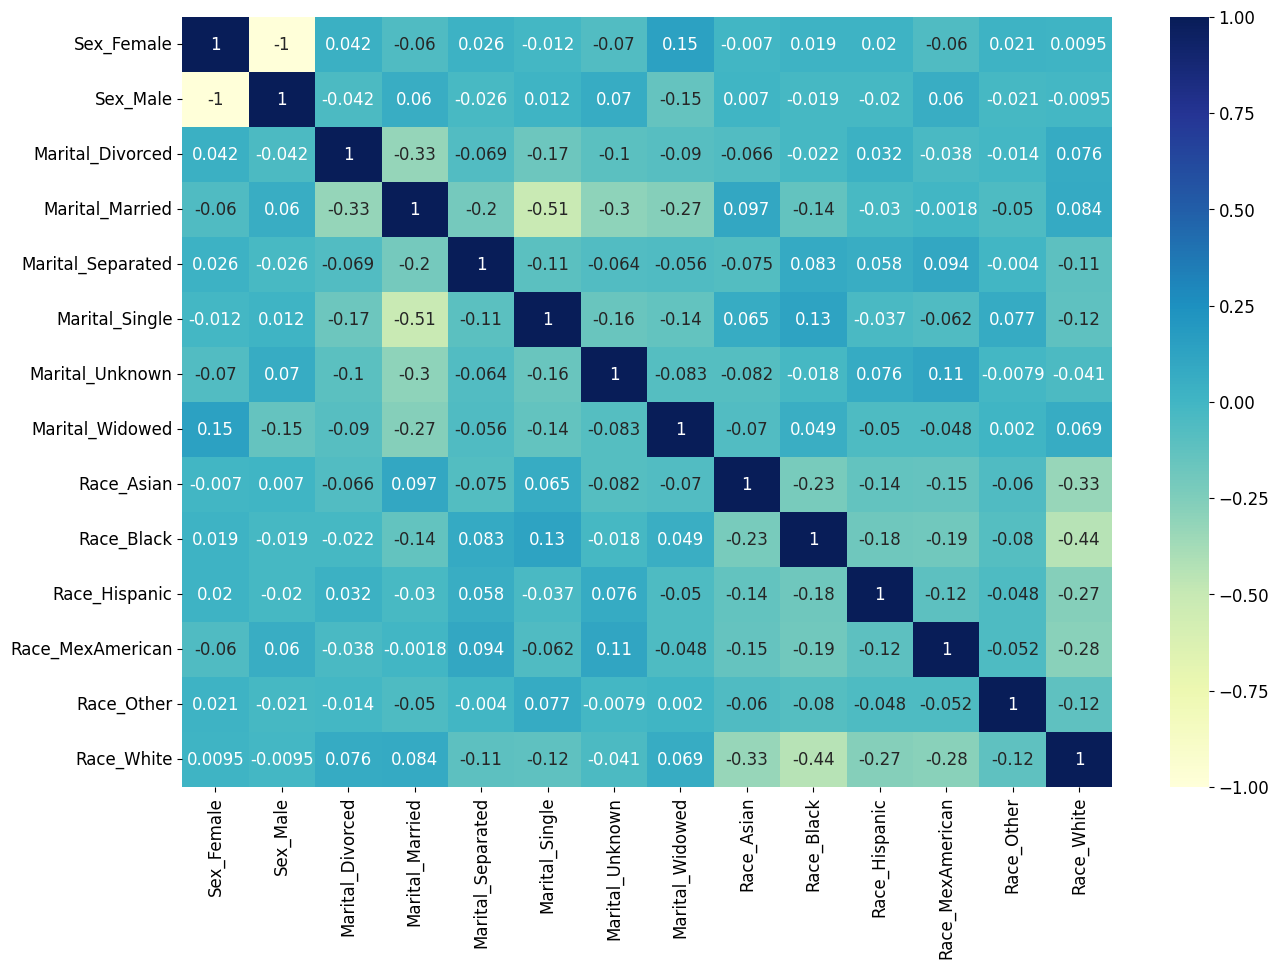

In [14]:
# Análisis de la correlación
plt.figure(figsize=(15, 10))
sns.heatmap(X_train_processed[encoded_cols].corr(), annot=True, cmap="YlGnBu")
plt.show()

Excluímos la información redundante eliminando una de las columnas:

In [15]:
X_train_processed.drop(['Sex_Female'], axis=1, inplace=True)

### Imputación de valores ausentes

In [16]:
# Lista con los nombres de las columnas numéricas 
numerical = df.select_dtypes(include = 'number').columns.drop('MetabolicSyndrome').tolist()

Una vez seleccionadas las muestras y codificadas las variables categóricas, usaremos técnicas de imputación para completar los valores ausentes del resto de variables. Análogamente, esto se hará primero en el conjunto de entrenamiento y luego podremos aplicar el modelo imputado al resto de *sets*.

Vimos que a medida que aumentaba la circunferencia de la cintura, así lo hacía el índice de masa corporal. Por lo tanto, la correlación entre *BMI* y *WaistCirc* nos permitirá completar las incógnitas en estas variables. Para lograrlo habrá que encontrar una fórmula estimada para la correlación lineal entre estas variables. 

In [17]:
# Usamos LinearRegression para obtener un modelo lineal de BMI ~ WaistCirc
# El índice de masa corporal es la variable respuesta y WaistCirc es la variable explicativa
predictor = 'WaistCirc'
response = 'BMI'

# Eliminamos observaciones con valores ausentes en estas columnas
X_train_temp = X_train_processed[['WaistCirc', 'BMI']].dropna()

reg = LinearRegression().fit(X_train_temp[[predictor]], X_train_temp[response])

print(f'Intercept: {reg.intercept_:.4f}')
print(f'Coefficient Exposure: {reg.coef_[0]:.4f}')

Intercept: -7.3522
Coefficient Exposure: 0.3664


El modelo lineal obtenido nos dice que *BMI = -7,3522 + 0,3664 × WaistCirc*. Podemos incluir en el diagrama de puntos la recta de regresión que representa el modelo ajustado anterior:

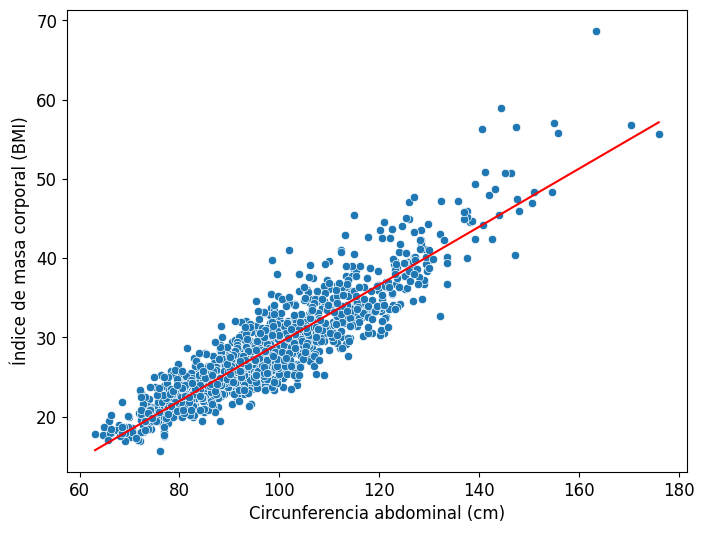

In [18]:
# Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_train_temp, x='WaistCirc', y='BMI')

# Añadimos la línea de regresión en rojo
x_values = np.linspace(X_train_temp['WaistCirc'].min(), X_train_temp['WaistCirc'].max(), 100)
y_values = reg.intercept_ + reg.coef_[0] * x_values
plt.plot(x_values, y_values, color='r', label=None)

plt.xlabel("Circunferencia abdominal (cm)")
plt.ylabel("Índice de masa corporal (BMI)")
plt.show()

Procedemos ahora a utilizar la relación anterior para resolver primero las incógnitas de la variable *BMI*:

In [19]:
# Observaciones donde BMI contiene valores ausentes
missing_rows = X_train_processed['BMI'].isna()
display(X_train_processed[numerical][missing_rows])

,Age,Income,WaistCirc,BMI,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
1409,26,2500.000,89.600,NaN,7.560,5.500,60,69,67
1423,70,NaN,115.400,NaN,2360.660,9.200,98,59,209
1722,51,NaN,127.400,NaN,252.690,9.300,94,48,289


In [20]:
# Creamos una función que devuelve el valor de BMI dado el valor de WaistCirc
def impute_bmi(with_WaistCirc):
    return np.round(reg.intercept_ + reg.coef_[0] * with_WaistCirc, 1) if not np.isnan(with_WaistCirc) else np.nan

# Aplicamos esta función a todos los valores ausentes
X_train_processed.loc[missing_rows, 'BMI'] = X_train_processed.loc[missing_rows, 'WaistCirc'].apply(impute_bmi)

display(X_train_processed[numerical][missing_rows])
print(f"Observaciones imputadas: {missing_rows.sum()}")

,Age,Income,WaistCirc,BMI,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
1409,26,2500.000,89.600,25.500,7.560,5.500,60,69,67
1423,70,NaN,115.400,34.900,2360.660,9.200,98,59,209
1722,51,NaN,127.400,39.300,252.690,9.300,94,48,289


Observaciones imputadas: 3


En sentido inverso, imputaremos la variable *WaistCirc*:

In [21]:
# Observaciones donde WaistCirc contiene valores ausentes
missing_rows = X_train_processed['WaistCirc'].isna()

In [22]:
# Creamos una función que devuelve el valor de WaistCirc dado el valor de BMI
def impute_waistcirc(with_BMI):
    return np.round((with_BMI - (reg.intercept_)) / reg.coef_[0], 1) if not np.isnan(with_BMI) else np.nan

# Aplicamos esta función a todos los valores ausentes
X_train_processed.loc[missing_rows, 'WaistCirc'] = X_train_processed.loc[missing_rows, 'BMI'].apply(impute_waistcirc)

display(X_train_processed[numerical][missing_rows])
print(f"Observaciones imputadas: {missing_rows.sum()}")

,Age,Income,WaistCirc,BMI,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
1547,56,300.000,122.700,37.600,31.010,6.000,169,45,371
151,29,3500.000,71.600,18.900,7.880,4.200,85,66,54
2051,78,2500.000,129.800,40.200,108.330,7.900,225,53,151
1542,80,1600.000,135.200,42.200,5928.000,8.100,120,60,169
2128,75,1600.000,86.400,24.300,36.460,6.300,102,77,45
2375,48,1000.000,183.000,59.700,22.110,5.800,152,57,107
503,75,2000.000,85.300,23.900,85.220,4.200,109,52,85
850,65,300.000,139.000,43.600,9.340,4.600,181,86,89
148,22,5400.000,108.200,32.300,2.720,4.400,97,46,96
2194,75,800.000,137.100,42.900,72.500,7.500,141,42,134


Observaciones imputadas: 41


Nos queda ya solo *Income* por limpiar de valores nulos. En este caso, en vez de explorar la correlación entre las columnas (variables), intentaremos utilizar las similitudes entre las filas (observaciones). Para ello usaremos un método basado en una variante de la distancia euclidiana para encontrar los vecinos más próximos (k-NN):

In [23]:
# Observaciones donde Income contiene valores ausentes
missing_rows = X_train_processed['Income'].isna()

In [24]:
# Imputamos todos los valores nulos utilizando los k vecinos más cercanos de cada caso
imputer = KNNImputer(n_neighbors=10)
X_train_imputed_array = imputer.fit_transform(X_train_processed)

# Imputamos los valores al set X_train_processed
X_train_imputed = pd.DataFrame(X_train_imputed_array, columns=X_train_processed.columns, index=X_train_processed.index)

# Para imputar valores de la variable Income que ya existan en el set, 
# seleccionamos los valores únicos y definimos una función que devuelva el valor más cercano
income_unique = X_train_processed['Income'].dropna().unique()
def nearest_income(value):
    return income_unique[np.argmin(np.abs(income_unique - value))]

# Aplicamos la función a los valores ausentes de Income que han sido imputados
income_missing_mask = X_train_processed['Income'].isna()
X_train_processed.loc[income_missing_mask, 'Income'] = X_train_imputed.loc[income_missing_mask, 'Income'].apply(nearest_income)

display(X_train_processed[numerical][missing_rows])
print(f"Observaciones imputadas: {missing_rows.sum()}")

,Age,Income,WaistCirc,BMI,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
128,55,5400.000,82.300,22.300,4.400,4.400,91,54,80
790,54,5400.000,104.400,28.400,3.570,5.400,106,57,65
546,24,4500.000,72.900,18.800,6.270,3.600,90,62,37
2326,40,5400.000,87.100,25.400,6.020,3.400,87,53,107
411,41,5400.000,98.700,33.500,6.260,3.800,92,44,154
496,69,2500.000,97.000,23.900,572.460,6.200,111,39,130
2049,48,4500.000,95.300,27.600,6.180,4.400,107,53,106
1565,70,4500.000,86.300,23.700,9.060,3.500,84,82,68
1925,80,3500.000,82.800,20.000,37.200,3.600,101,74,60
1001,40,4500.000,119.000,33.200,5.200,6.500,114,46,126


Observaciones imputadas: 58


Ahora podemos comparar la distribuciones de *Income* antes y después de la imputación:

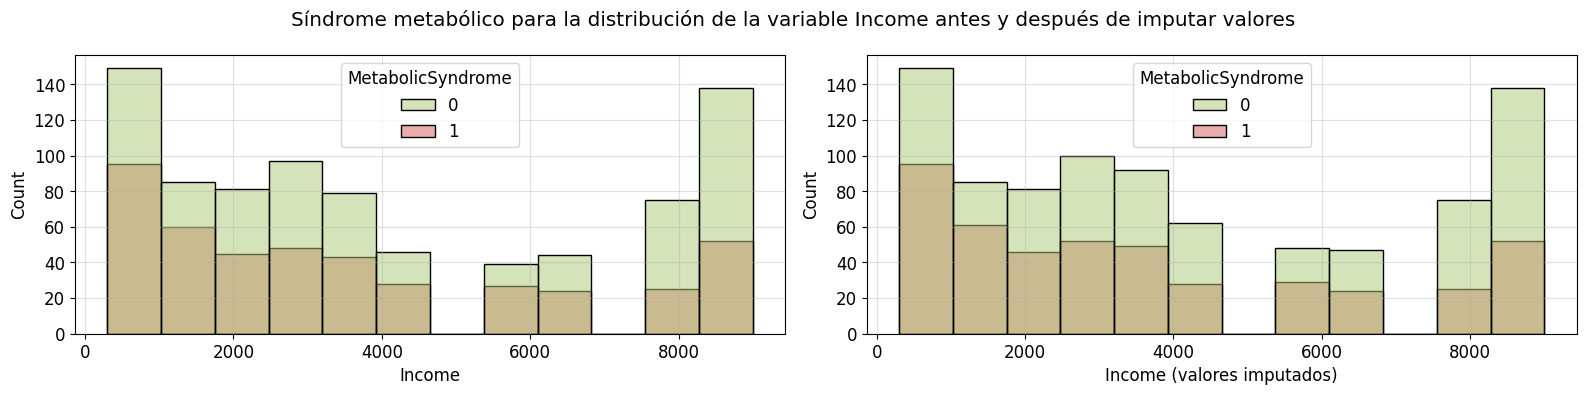

In [25]:
# Distribuciones de X_train y X_train_processed con respecto a Income
fig, axs = plt.subplots(1, 2, figsize=(16,4))

colors = ['#ABC875', '#D75C58']

sns.histplot(data=X_train,
                 x=X_train['Income'],
                 hue=y_train,
                 palette=colors,
                 ax=axs[0])
axs[0].grid(alpha=0.4)
    
sns.histplot(data=X_train_processed,
                 x=X_train_processed['Income'],
                 hue=y_train,
                 palette=colors,
                 ax=axs[1])
axs[1].grid(alpha=0.4)
axs[1].set(xlabel='Income (valores imputados)')
    
fig.suptitle('Síndrome metabólico para la distribución de la variable Income antes y después de imputar valores')
plt.tight_layout(pad=1)
plt.show()

### Correlación entre variables

Nos hemos servido de la correlación que existe entre *BMI* y *WaistCirc* para imputar sus valores ausentes en el *set* de entrenamiento. Sin embargo, la alta correlación entre el índice de masa corporal y la circunferencia de la cintura enfatiza la necesidad de una posible consideración de la multicolinealidad. Significa que ambas aportan información redundante al juego de datos y, en consecuencia, podemos prescindir de una de ellas.

In [26]:
# Eliminamos variable BMI por colinealidad con WaistCirc
X_train_processed.drop('BMI', axis=1, inplace=True)
numerical.remove('BMI')

### Escalado por estandarización

Escalamos ahora las variables numéricas, de modo que se pueda comparar la magnitud de cada característica. Aplicaremos estandarización con `StandardScaler()`, cuyo método `fit()` calcula la media y la desviación estándar del conjunto de entrenamiento y `transform()` se encarga de substraer la primera y dividir por la segunda a cada muestra. Se consigue así que para cada variable la media sea cero y la varianza uno. Este proceso también se acostumbra a llamar normalización, aunque el término puede referirse únicamente a una [transformación diferente, como es en la forma de la distribución en vez de en el rango de valores](https://www.kaggle.com/code/alexisbcook/scaling-and-normalization).

In [27]:
# Estandarizamos el conjunto de entrenamiento
scaler = StandardScaler()

# Configuramos ahora ColumnTransformer para evitar las ya codificadas
norm = ColumnTransformer(
    transformers=[('norm', scaler, numerical)],
    remainder='passthrough', # keep any other columns unchanged
    verbose_feature_names_out=False
)
# La salida como dataframe
norm.set_output(transform="pandas")

norm.fit(X_train_processed)
X_train_processed_norm = norm.transform(X_train_processed)

display(X_train_processed_norm)

,Age,Income,WaistCirc,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,Sex_Male,Marital_Divorced,...,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,Race_MexAmerican,Race_Other,Race_White
2284,1.806,-0.171,-0.590,-0.122,-0.756,-0.286,1.984,0.274,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
801,1.404,-0.825,-0.334,-0.081,-0.340,0.210,1.264,-0.586,1.000,0.000,...,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
624,-1.640,-0.515,0.112,-0.111,-0.617,-0.636,-0.572,-0.711,0.000,0.000,...,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
543,-1.008,-0.171,0.844,-0.130,0.909,-0.578,-0.768,-0.564,1.000,0.000,...,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1173,-0.376,-0.825,1.839,-0.139,0.077,0.094,-0.965,0.364,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.141,-0.825,0.423,0.139,-0.340,0.823,0.805,-0.450,0.000,0.000,...,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
1233,1.117,-1.032,0.588,-0.133,-0.131,0.619,0.608,-0.360,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
840,0.026,0.174,-0.987,-0.126,-0.756,-0.548,1.722,-0.824,0.000,0.000,...,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
811,0.887,-0.688,0.362,-0.123,0.285,0.094,-0.768,1.711,0.000,0.000,...,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000


Entre los modelos que usaremos, solo la *Logistic Regression* requiere los datos en un mismo rango para su convergencia. Los modelos basados en árboles no son sensibles a este asunto y, por ello, aplicaremos este *set* normalizado únicamente cuando entrenemos el modelo de la regresión logística.

### Aplicación al resto de sets

Preprocesamos a continuación el resto de conjuntos, aplicando las mismas transformaciones:

In [28]:
# Conjunto de validación

# Codificación de las variables categóricas
X_val_processed = ohe.transform(X_val)
X_val_processed.drop(['Sex_Female'], axis=1, inplace=True)
# Imputación de valores ausentes
numerical = df.select_dtypes(include = 'number').columns.drop('MetabolicSyndrome').tolist()
missing_rows = X_val_processed['BMI'].isna()
X_val_processed.loc[missing_rows, 'BMI'] = X_val_processed.loc[missing_rows, 'WaistCirc'].apply(impute_bmi)
print(f"Observaciones imputadas para BMI: {missing_rows.sum()}")
missing_rows = X_val_processed['WaistCirc'].isna()
X_val_processed.loc[missing_rows, 'WaistCirc'] = X_val_processed.loc[missing_rows, 'BMI'].apply(impute_waistcirc)
print(f"Observaciones imputadas para WaistCirc: {missing_rows.sum()}")
missing_rows = X_val_processed['Income'].isna()
X_val_imputed_array = imputer.transform(X_val_processed)
X_val_imputed = pd.DataFrame(X_val_imputed_array, columns=X_val_processed.columns, index=X_val_processed.index)
income_missing_mask = X_val_processed['Income'].isna()
X_val_processed.loc[income_missing_mask, 'Income'] = X_val_imputed.loc[income_missing_mask, 'Income'].apply(nearest_income)
print(f"Observaciones imputadas para Income: {missing_rows.sum()}")
# Multicolinealidad
X_val_processed.drop('BMI', axis=1, inplace=True)
numerical.remove('BMI')
# Normalización
X_val_processed_norm = norm.transform(X_val_processed)
display(X_val_processed)

Observaciones imputadas para BMI: 2
Observaciones imputadas para WaistCirc: 8
Observaciones imputadas para Income: 22


,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,...,Race_Other,Race_White,Age,Income,WaistCirc,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
43,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,38,4500.000,103.800,3.600,4.900,96,49,88
2225,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,1.000,48,2000.000,92.600,6.090,5.200,93,34,137
997,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,61,2500.000,97.600,2.840,6.700,95,59,167
1421,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,33,9000.000,76.600,5.570,3.300,88,64,77
1713,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,1.000,0.000,21,300.000,82.000,11.770,3.300,88,47,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,1.000,80,2000.000,79.800,5.350,5.000,98,90,78
803,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,28,1000.000,106.300,2.610,5.300,97,39,92
144,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,37,5400.000,114.800,4.930,5.600,87,44,81
810,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,63,9000.000,115.500,39.640,8.000,101,39,291


In [29]:
# Conjunto de entrenamiento completo (train + validation)

# Codificación de las variables categóricas
X_train_full_processed = ohe.transform(X_train_full)
X_train_full_processed.drop(['Sex_Female'], axis=1, inplace=True)
# Imputación de valores ausentes
numerical = df.select_dtypes(include = 'number').columns.drop('MetabolicSyndrome').tolist()
missing_rows = X_train_full_processed['BMI'].isna()
X_train_full_processed.loc[missing_rows, 'BMI'] = X_train_full_processed.loc[missing_rows, 'WaistCirc'].apply(impute_bmi)
print(f"Observaciones imputadas para BMI: {missing_rows.sum()}")
missing_rows = X_train_full_processed['WaistCirc'].isna()
X_train_full_processed.loc[missing_rows, 'WaistCirc'] = X_train_full_processed.loc[missing_rows, 'BMI'].apply(impute_waistcirc)
print(f"Observaciones imputadas para WaistCirc: {missing_rows.sum()}")
missing_rows = X_train_full_processed['Income'].isna()
X_train_full_imputed_array = imputer.transform(X_train_full_processed)
X_train_full_imputed = pd.DataFrame(X_train_full_imputed_array, columns=X_train_full_processed.columns, index=X_train_full_processed.index)
income_missing_mask = X_train_full_processed['Income'].isna()
X_train_full_processed.loc[income_missing_mask, 'Income'] = X_train_full_imputed.loc[income_missing_mask, 'Income'].apply(nearest_income)
print(f"Observaciones imputadas para Income: {missing_rows.sum()}")
# Multicolinealidad
X_train_full_processed.drop('BMI', axis=1, inplace=True)
numerical.remove('BMI')
# Normalización
X_train_full_processed_norm = norm.transform(X_train_full_processed)
display(X_train_full_processed)

Observaciones imputadas para BMI: 5
Observaciones imputadas para WaistCirc: 49
Observaciones imputadas para Income: 80


,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,...,Race_Other,Race_White,Age,Income,WaistCirc,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
835,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,30,4500.000,99.900,10.000,5.500,104,48,44
676,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,74,1600.000,107.200,454.740,7.600,140,21,681
1382,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,23,2000.000,143.300,64.040,6.400,94,34,120
644,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,42,4500.000,82.000,3.250,5.200,90,75,45
1933,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,31,2000.000,80.500,7.440,4.200,94,56,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,56,9000.000,90.600,27.270,5.800,104,62,119
750,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,80,4500.000,98.700,3.500,3.500,77,60,46
156,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,21,9000.000,73.000,7.920,3.800,94,54,49
326,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,...,0.000,1.000,24,2000.000,94.600,4.770,3.900,90,52,81


In [30]:
# Conjunto de prueba

# Codificación de las variables categóricas
X_test_processed = ohe.transform(X_test)
X_test_processed.drop(['Sex_Female'], axis=1, inplace=True)
# Imputación de valores ausentes
numerical = df.select_dtypes(include = 'number').columns.drop('MetabolicSyndrome').tolist()
missing_rows = X_test_processed['BMI'].isna()
X_test_processed.loc[missing_rows, 'BMI'] = X_test_processed.loc[missing_rows, 'WaistCirc'].apply(impute_bmi)
print(f"Observaciones imputadas para BMI: {missing_rows.sum()}")
missing_rows = X_test_processed['WaistCirc'].isna()
X_test_processed.loc[missing_rows, 'WaistCirc'] = X_test_processed.loc[missing_rows, 'BMI'].apply(impute_waistcirc)
print(f"Observaciones imputadas para WaistCirc: {missing_rows.sum()}")
missing_rows = X_test_processed['Income'].isna()
X_test_imputed_array = imputer.transform(X_test_processed)
X_test_imputed = pd.DataFrame(X_test_imputed_array, columns=X_test_processed.columns, index=X_test_processed.index)
income_missing_mask = X_test_processed['Income'].isna()
X_test_processed.loc[income_missing_mask, 'Income'] = X_test_imputed.loc[income_missing_mask, 'Income'].apply(nearest_income)
print(f"Observaciones imputadas para Income: {missing_rows.sum()}")
# Multicolinealidad
X_test_processed.drop('BMI', axis=1, inplace=True)
numerical.remove('BMI')
# Normalización
X_test_processed_norm = norm.transform(X_test_processed)
display(X_test_processed)

Observaciones imputadas para BMI: 0
Observaciones imputadas para WaistCirc: 4
Observaciones imputadas para Income: 10


,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,...,Race_Other,Race_White,Age,Income,WaistCirc,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
22,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,61,9000.000,90.800,2.340,5.300,102,39,135
2054,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,39,1000.000,85.000,26.010,4.000,87,64,102
616,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,22,3500.000,79.600,11.370,2.700,84,14,57
282,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,...,0.000,0.000,78,2500.000,97.000,535.850,7.800,244,53,126
921,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,62,8200.000,79.900,6.080,6.400,86,56,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,50,9000.000,103.600,24.460,7.400,101,57,93
2373,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,31,2500.000,74.000,2.000,6.700,95,64,81
1003,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,27,2500.000,77.800,19.140,4.000,89,82,73
599,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,0.000,0.000,59,8200.000,84.300,4.620,4.400,93,54,240


In [31]:
# Conjunto de calibración

# Codificación de las variables categóricas
X_cal_processed = ohe.transform(X_cal)
X_cal_processed.drop(['Sex_Female'], axis=1, inplace=True)
# Imputación de valores ausentes
numerical = df.select_dtypes(include = 'number').columns.drop('MetabolicSyndrome').tolist()
missing_rows = X_cal_processed['BMI'].isna()
X_cal_processed.loc[missing_rows, 'BMI'] = X_cal_processed.loc[missing_rows, 'WaistCirc'].apply(impute_bmi)
print(f"Observaciones imputadas para BMI: {missing_rows.sum()}")
missing_rows = X_cal_processed['WaistCirc'].isna()
X_cal_processed.loc[missing_rows, 'WaistCirc'] = X_cal_processed.loc[missing_rows, 'BMI'].apply(impute_waistcirc)
print(f"Observaciones imputadas para WaistCirc: {missing_rows.sum()}")
missing_rows = X_cal_processed['Income'].isna()
X_cal_imputed_array = imputer.transform(X_cal_processed)
X_cal_imputed = pd.DataFrame(X_cal_imputed_array, columns=X_cal_processed.columns, index=X_cal_processed.index)
income_missing_mask = X_cal_processed['Income'].isna()
X_cal_processed.loc[income_missing_mask, 'Income'] = X_cal_imputed.loc[income_missing_mask, 'Income'].apply(nearest_income)
print(f"Observaciones imputadas para Income: {missing_rows.sum()}")
# Multicolinealidad
X_cal_processed.drop('BMI', axis=1, inplace=True)
numerical.remove('BMI')
display(X_cal_processed)

Observaciones imputadas para BMI: 0
Observaciones imputadas para WaistCirc: 11
Observaciones imputadas para Income: 26


,Sex_Male,Marital_Divorced,Marital_Married,Marital_Separated,Marital_Single,Marital_Unknown,Marital_Widowed,Race_Asian,Race_Black,Race_Hispanic,...,Race_Other,Race_White,Age,Income,WaistCirc,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
360,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,80,5400.000,94.500,36.270,7.500,190,50,118
630,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,68,2000.000,111.600,7.680,3.900,121,57,141
1902,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,80,1000.000,75.000,28.200,4.900,106,59,131
1698,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,80,2500.000,108.400,99.150,5.200,142,70,83
2085,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,29,2500.000,77.200,6.000,3.500,87,90,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,41,9000.000,90.500,2.990,5.300,100,33,354
1605,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,0.000,24,9000.000,83.400,8.570,4.300,93,46,61
57,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,20,3500.000,87.800,1.730,6.300,94,45,86
2276,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,1.000,48,4500.000,92.200,2.990,5.200,96,42,148


Tenemos ahora preparados todos los *sets* para la aplicación y evaluación de los modelos. Guardamos antes los conjuntos que requeriremos en futuros cuadernos:

In [32]:
X_train_full_processed.to_csv("metabolic_syndrome_x_train.csv", index=False)
y_train_full.to_csv("metabolic_syndrome_y_train.csv", index=False)
X_test_processed.to_csv("metabolic_syndrome_x_test.csv", index=False)
y_test.to_csv("metabolic_syndrome_y_test.csv", index=False)
X_cal_processed.to_csv("metabolic_syndrome_x_cal.csv", index=False)
y_cal.to_csv("metabolic_syndrome_y_cal.csv", index=False)

## Entrenamiento de los modelos

Vamos a entrenar y evaluar los siguientes modelos supervisados de clasificación binaria:

- Logistic Regression (regresión logistica)
- Decision Tree (árbol de decisión)
- Random Forest (bosque aleatorio)
- Gradient boosting machines (máquinas de aumento de gradiente):
  - XGBoost 
  - CatBoost
  - LightGBM

Para cualquiera de estos modelo esperamos que, cuando los evaluemos con datos nuevos, funcionen (en promedio) tan bien como lo han hecho en la fase de entrenamiento. La metodología a seguir en todos los casos va a consistir en dar con un modelo entrenado satisfactorio, ajustar el umbral de decisión para mejorar la clasificación y resumir las métricas para poder compararlos posteriormente. Para lo primero emplearemos una búsqueda con el método `GridSearchCV()` sobre el conjunto de entrenamiento, que convenientemente incorpora validación cruzada a la búsqueda exhaustiva en todas las combinaciones de parámetros. Una vez obtengamos los mejores hiperparámetros evaluaremos el modelo con el conjunto de validación. Aquí nos centraremos en encontrar un *threshold* que siga ajustando al modelo para optimizar una determinada métrica.

### Métricas de evaluación

La métrica habitual de evaluación es la *accuracy* (exactitud). Una métrica menos sensible en conjuntos de datos con clases no balanceadas es la *balanced_accuracy*, que pone la exactitud en perspectiva, pero ésta no es más que la media de la métrica *recall* para cada clase. Siendo en nuestro problema la clase más relevante (y ligeramente menos frecuente) la clase positiva, disponemos del *F1-score* como medida más específica, que tiene en cuenta la bondad del modelo a la hora de predecir correctamente la clase objetivo, obteniendo un valor entre 0 (mal resultado) y 1 (buen resultado). Decidimos optimizar por esta métrica, como veremos en las conclusiones al aplicar un modelo incial de referencia (la regresión logística), aunque se calcurán además la *accuracy*, precisión, *recall* y ROC AUC.

### Logistic Regression

La regresión logística es un modelo linear cuya salida se acomoda generalmente a un resultado binario mediante la función sigmoide aplicada a la salida del modelo sin procesar. Como algoritmos de regresión para entrenar el modelo usaremos, a parte de `lbfgs` (el *solver* por defecto), `liblinear` que también funciona bien en *datasets* pequeños, `saga`que usa *gradient descent* y `newton-cholesky` para clasificación binaria y una buena elección cuando el número de observaciones es mucho mayor que el número de características. Los argumentos `penalty` y `C` se usan para prevenir *overfitting*. Si queremos ajustar el modelo sin esta regularización, daríamos a `C` un valor muy grande.

In [33]:
# Classifier Logistic Regression
model_lr = LogisticRegression(random_state=23)

# Hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],     # l1 lasso, l2 ridge, elasticnet use both, default is l2
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1e10],       # smaller values specify stronger regularization, default 1
    'solver': ['lbfgs', 'liblinear', 'newton-cholesky', 'saga'],  # default lbfgs  
    'max_iter': [10, 25, 50, 100, 200]               # max iterations taken for the solvers to converge, default 100
}

# Create grid search and train the model
# n_jobs set up to None to avoid warnings
grid_lr = GridSearchCV(model_lr, param_grid, scoring=metric, n_jobs=None, cv=5)
%time grid_lr.fit(X_train_processed_norm, y_train)

# Summarize
best_lr = summarize_training(grid_lr)

CPU times: user 45.6 s, sys: 1min 52s, total: 2min 37s
Wall time: 15.3 s
Best Mean F1-score: 0.737
Standard Deviation: 0.027
Best Parameters: {'C': 0.001, 'max_iter': 25, 'penalty': None, 'solver': 'lbfgs'}


Una desviación estándar pequeña es una señal de que el modelo logra captar la relación entre los datos y la clase objetivo, concluyendo en que el resultado es robusto. La puntuación media de *F1-score* es de apróximadamente 74%. Evaluamos ahora el modelo usando los mejores valores de los hiperparámetros:

In [34]:
# Probamos el modelo con los mejores parámetros
y_pred = best_lr.predict(X_val_processed_norm)

# Métricas: exactitud, precisión, recall y F1-score
print(classification_report(y_val, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       293
           1       0.78      0.72      0.75       154

    accuracy                           0.83       447
   macro avg       0.82      0.81      0.81       447
weighted avg       0.83      0.83      0.83       447



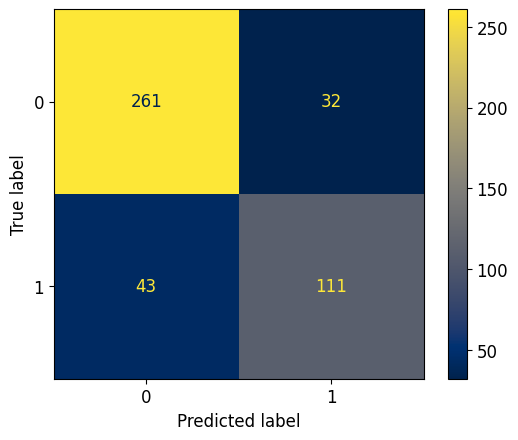

In [35]:
# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap = 'cividis')

El modelo predijo correctamente el ~83% de las veces y diagnosticó erróneamente al ~17% de las personas. En la matriz de confusión observamos como el número de Falsos Negativos es de 43 (personas con síndrome metabólico que no han sido diagnosticadas). Un resultado un poco desalentador, por lo que intentaremos reducir este número ajustando el umbral de decisión. En teoría, un punto de corte inferior suele ser apropiado si el objetivo es identificar miembros de la clase menos común.

Una vez entrenado el modelo, el método de predicción para la clasificación binaria genera las etiquetas correspondientes a la clase dependiendo de un umbral aplicado a la salida de `predict_proba()`. A pesar de lo que indica su nombre, las puntuaciones crudas (*raw scores*) que arroja esta función no deben interpretarse como probabilidades. [Lo parecen, pero por lo general no están calibradas](https://kiwidamien.github.io/are-you-sure-thats-a-probability.html). Lo estarían si, por ejemplo, entre todas las clasificaciones con una puntuación del 90%, encontramos la clase positiva 9 de cada 10 veces. Para garantizar tal hecho, en un cuaderno posterior veremos como calibrar estas puntuaciones crudas para convertirlas en verdaderas probabilidades. Por el momento, `predict_proba()` devuelve un vector, donde la primera columna contiene las *raw scores* para el ejemplo de entrenamiento perteneciendo a la primera clase (0) y la segunda columna contiene la puntuaciones crudas del ejemplo para la segunda clase (1). El umbral predeterminado está definido como 0,5, que podría no ser óptimo si nuestro interés es maximizar el *F1-score*. Con tal de encontrar un mejor valor para este "punto de corte", que maximice el *F1-score*, usaremos `TunedThresholdClassifierCV()` de la siguiente manera:

In [36]:
# Pasamos nuestro mejor modelo, la métrica seleccionada y el conjunto de validación
tuned_lr = TunedThresholdClassifierCV(best_lr, cv='prefit', refit=False, scoring=metric).fit(X_val_processed_norm, y_val)

# Imprime resumen de los resultados
print(f'Best Mean Training Set {METRIC_NAME}: %.3f' % tuned_lr.best_score_)
print(f'Tuned Model Validation Set {METRIC_NAME}: %.3f' % f1_score(y_val, tuned_lr.predict(X_val_processed_norm)))
print(f'Original Model Validation Set {METRIC_NAME}: %.3f' % f1_score(y_val, best_lr.predict(X_val_processed_norm)))
print(f'New Threshold: %.3f' % tuned_lr.best_threshold_)

Best Mean Training Set F1-score: 0.783
Tuned Model Validation Set F1-score: 0.783
Original Model Validation Set F1-score: 0.747
New Threshold: 0.274


`TunedThresholdClassifierCV` utiliza por defecto validación cruzada, algo que queremos evitar, pues estamos pasándole un modelo ya ajustado. Ya hemos entrenado nuestro modelo y lo que deseamos es encontrar el mejor umbral de decisión con el conjunto de validación. Si lo entrenaramos de nuevo con el set de entrenamiento acabaríamos sobreajustándolo. Por ello usamos `cv='prefit'` y `refit=False`.

Vemos en la salida, que un *threshold* de 0,274 ha mejorado el *F1-score* del mejor modelo de 0,747 a 0,783. Como consecuencia el número de Falsos Negativos habrá descendido, pero suponemos que a costa de tener más Falsos Positivos. Lo confirmamos con la matriz de confusión:

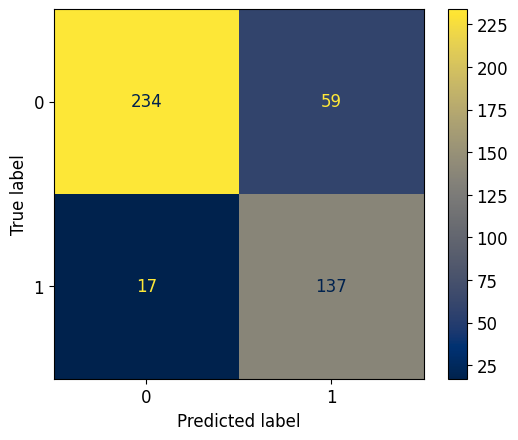

In [37]:
# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, tuned_lr.predict(X_val_processed_norm), cmap = 'cividis')

Vamos a integrar este procedimiento y visualizar ahora las puntuaciones de las métricas para diferentes umbrales de decisión:

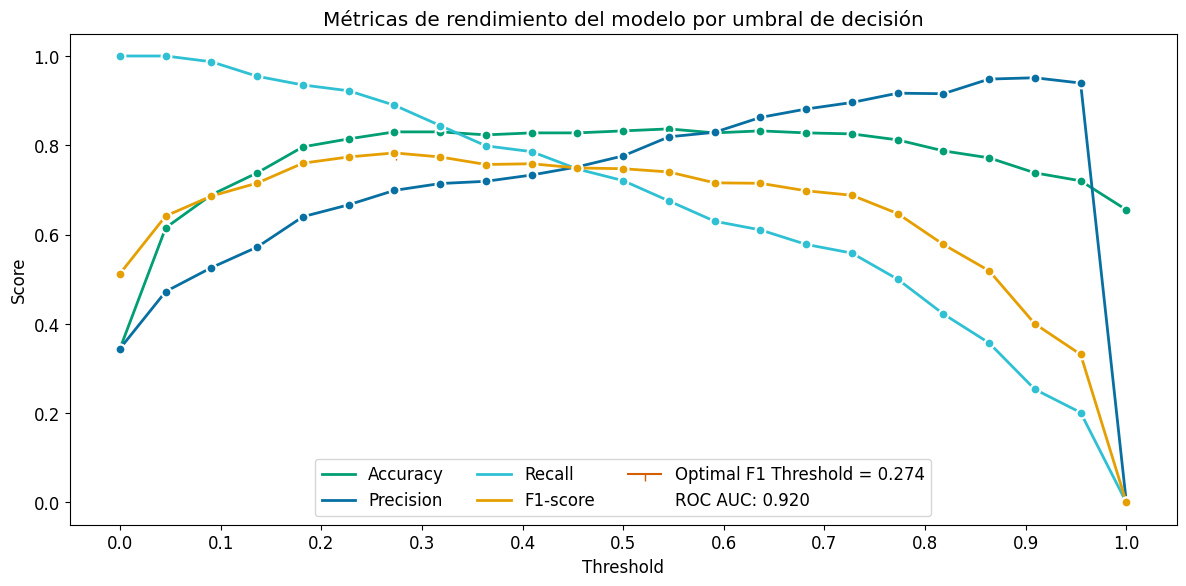

In [38]:
df_metrics, threshold_lr = tune_and_plot_threshold(best_lr, X_val_processed_norm, y_val)

Podemos interpretar lo siguiente:

- Un *recall* igual a 1 se obtiene con un umbral de 0, es decir, todas las observaciones se clasifican como positivas y por tanto no se obtienen Falsos Negativos, pero clasifica incorrectamente todos los Verdaderos Negativos. En el caso de nuestro conjunto de validación, tendríamos la matriz de confusión con TN = FN = 0, FP = 293 y TP = 154. Lo que resuelve en una *accuracy* de TP / (TP + FN), que es precisamente la fórmula de la precisión. Esto es justamente lo que se observa en el gráfico, con un valor de ~0,34, que no es más que la proporción de personas diagnósticadas con síndrome metabólico en el *set* de validación.

- El punto donde se cruzan las líneas de *recall* y precisión representa un buen compromiso en cuanto a identificar correctamente las muestras diagnosticadas sin producir demasiados Falsos Positivos. Ahora, para nuestro problema, el coste de los Falsos Negativos (clasificar como sanas a personas con síndrome metabólico) lo consideramos mayor, con lo que deberíamos elegir un umbral que favorezca el *recall*. Aquí entra en juego el *F1-score*, que siendo la media armónica de precisión y *recall*, suele ser la más alta o cercana a su pico en este punto de cruce, ya que se maximiza cuando ambas métricas se acercan al equilibrio.

- Un umbral de 1, es decir, clasificar todas las observaciones como negativas, hace lógicamente que el valor de *accuracy* sea el de la distribución de ceros en el conjunto de validación, esto es, ~65,5%. En este caso TN = 293, FN = 154 y FP = TP = 0, que hace que el valor de *accuracy* sea efectivamente 0,65. El resto de métricas consecuentemente se desploman a 0.

In [39]:
# Mostramos el resumen de métricas para el valor de threshold dado por TunedThresholdClassifierCV
val_metrics_lr = train_val_metrics(best_lr, X_train_processed_norm, y_train, X_val_processed_norm, y_val, threshold_lr)

Metric,Training Set,Validation Set
Accuracy,0.812000,0.830000
F1-score,0.764000,0.783000
Recall,0.883000,0.890000
Precision,0.673000,0.699000
ROC AUC,0.911000,0.920000


La comparación de las métricas para el conjunto de entrenamiento y el de validación con el modelo ajustado a este nuevo *threshold* muestra unos rendimientos similares, que indican que el modelo generaliza bien y no hay *overfitting*.

### Decision Tree

Los algoritmos de aprendizaje basados en árboles abordan mejor la no linealidad en los datos disponibles. Además, los árboles de decisión destacan por su facilidad de interpretación. Dividen los datos basándose en el concepto de "pureza" del nodo, una medida de cuántos de sus datos pertenecen a una sola clase, tratando de maximizar el decremento de impureza en cada división. Como criterios para medirla usamos los habituales en clasificación: `gini` y `entropy`, acompañados de la estrategia para elegir la división. El resto de hiperparámetros que tendremos en cuenta definirán restricciones sobre el tamaño del árbol: `max_depth`para la máxima profundidad del árbol (vertical), `min_samples_split` para el mínimo de observaciones para dividir un nodo y, en el caso de hojas, `min_samples_leaf`, de los que nos aseguraremos unos mínimos para no aumentar la complejidad de los árboles.

In [40]:
# Classifier Decision Tree
model_dt = DecisionTreeClassifier(random_state=23)

# Hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],                # function to measure quality of a split, default gini
    'splitter': ['best', 'random'],                  # strategy to chooose the split, default best
    'max_depth': [4, 6, 8, None],                    # maximum depth of the tree, default None
    'min_samples_split': [6, 8, 10, 20],             # minimum number of samples to split a node, default 2
    'min_samples_leaf': [8, 10, 15, 20, 30, 50]      # default 1
}

# Create grid search and train the model
grid_dt = GridSearchCV(model_dt, param_grid, scoring=metric, n_jobs=-1, cv=5)
%time grid_dt.fit(X_train_processed, y_train)

# Summarize
best_dt = summarize_training(grid_dt)

CPU times: user 459 ms, sys: 178 ms, total: 638 ms
Wall time: 1.89 s
Best Mean F1-score: 0.811
Standard Deviation: 0.021
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 8, 'min_samples_split': 20, 'splitter': 'best'}


              precision    recall  f1-score   support

           0       0.90      0.91      0.91       293
           1       0.83      0.80      0.81       154

    accuracy                           0.87       447
   macro avg       0.86      0.86      0.86       447
weighted avg       0.87      0.87      0.87       447



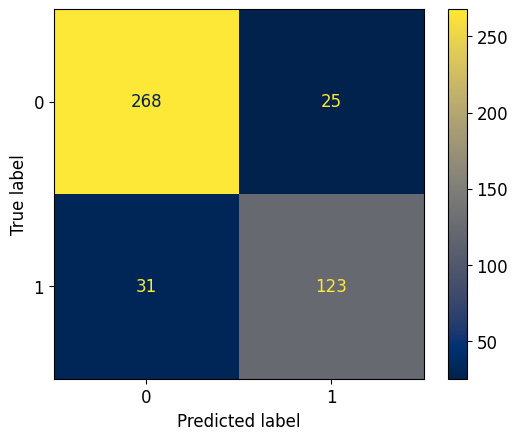

In [41]:
# Probamos el modelo con los mejores parámetros
y_pred = best_dt.predict(X_val_processed)

# Métricas: exactitud, precisión, recall y F1-score
print(classification_report(y_val, y_pred, digits=2))

# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap = 'cividis')

Parece que vamos a poder mejorar el modelo inicial. Busquemos ahora el umbral óptimo:

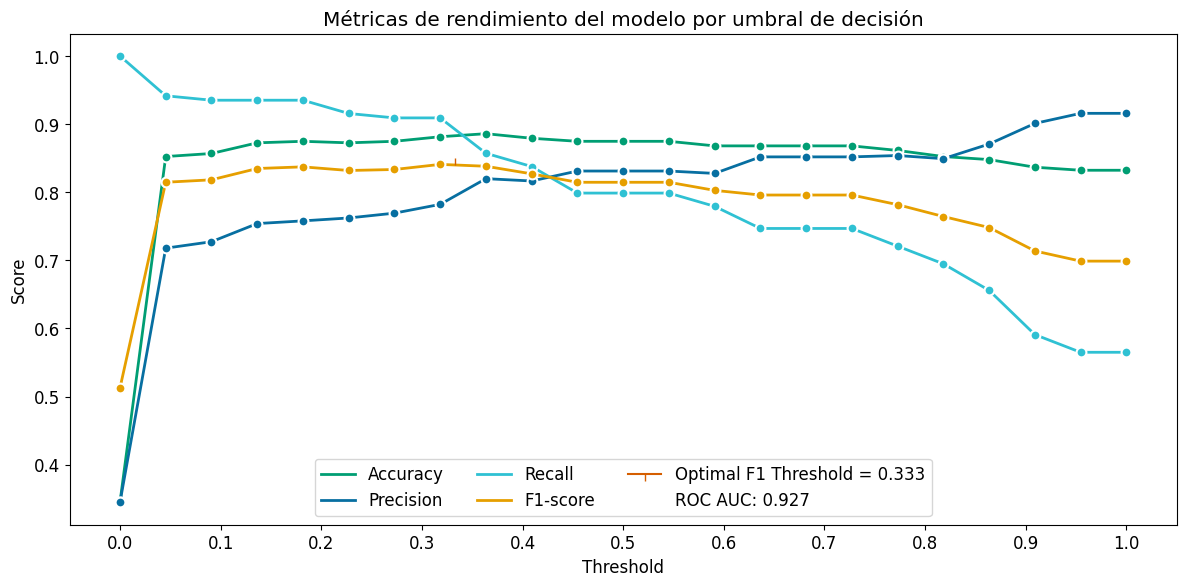

In [42]:
df_metrics, threshold_dt = tune_and_plot_threshold(best_dt, X_val_processed, y_val)

Obtenemos ahora las métricas para el modelo ajustado al nuevo umbral de 0,333:

Metric,Training Set,Validation Set
Accuracy,0.921000,0.890000
F1-score,0.892000,0.850000
Recall,0.946000,0.903000
Precision,0.843000,0.803000
ROC AUC,0.985000,0.927000


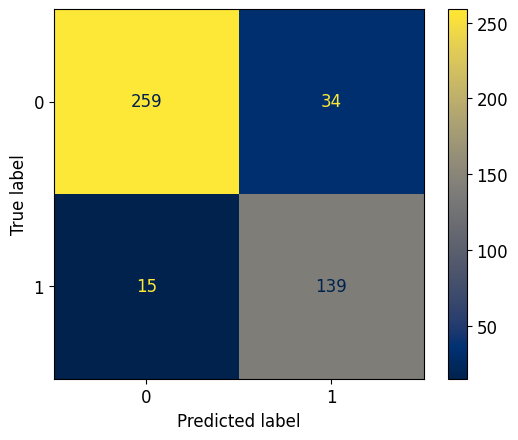

In [43]:
# Resumen de métricas para el mejor modelo con ajuste de umbral
val_metrics_dt = train_val_metrics(best_dt, X_train_processed, y_train, X_val_processed, y_val, threshold_dt)
# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, best_dt.predict_proba(X_val_processed)[:,1] >= threshold_dt, cmap = 'cividis')

El árbol de decisión con umbral 0,333 resulta en dos Falsos Negativos menos que el modelo anterior tuneado, pero también 25 Falsos Postivos menos, lo que en general mejora la clasificación, siendo todas las métricas superiores. Los árboles de decisión son muy sensibles a pequeñas variaciones en el conjunto de entrenamiento y se sobreajustan a menudo para este *set*, pero aumentando el número de muestras necesarias para dividir nodos y hojas se ha conseguido disipar el riesgo de *overfitting*.

### Random Forest

La idea detrás de *ensemble learning* es la de un "metamodelo" que agregue las predicciones de un conjunto de modelos individuales y genere una predicción final. Si este conjunto está formado por la misma base de algoritmos, donde, en vez de entrenar cada modelo con el conjunto de entrenamiento, los entrenamos con una muestra diferente de este *set*, estamos ante la familia de *boostrap aggregation* (o *bagging*). *Random forest* es uno de estos métodos que usa árboles de decisión como estimador base.

Con la intención de mejorar la predicción y reducir los posibles problemas de *overfitting* de los árboles de decisión, vamos entonces a utilizar ahora *random forest* que, en términos básicos, será el promedio de múltiples árboles de decisión (“un bosque de árboles construido con aleatoriedad”). Podemos ajustar el número de árboles con `n_estimators`, así como los hiperparámetros habituales de éstos, como el número de veces que se pueden dividir las ramas y el tamaño de las divisiones. Además, con `max_features` ajustamos el número de variables que deciden cada división.

In [44]:
# Classifier Random Forest
model_rfb = RandomForestClassifier(random_state=23)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],        # number of trees in the forest, default 100
    'criterion': ['gini', 'entropy'],       # function to measure the quality of a split, default gini
    'max_depth': [5, 8, 10, 15, 20, 30],    # default none
    'min_samples_split': [2, 5, 10],        # default 2
    'min_samples_leaf': [5, 8, 10],         # default 1
    'max_features': ['sqrt', 'log2', None]  # default sqrt
}

# Creade grid search and train the model
grid_rf = GridSearchCV(model_rfb, param_grid, scoring=metric, n_jobs=-1, cv=5)
%time grid_rf.fit(X_train_processed, y_train)

# Summarize
best_rfb = summarize_training(grid_rf)

CPU times: user 6.73 s, sys: 1.14 s, total: 7.87 s
Wall time: 2min 18s
Best Mean F1-score: 0.834
Standard Deviation: 0.018
Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}


              precision    recall  f1-score   support

           0       0.91      0.90      0.91       293
           1       0.82      0.82      0.82       154

    accuracy                           0.88       447
   macro avg       0.86      0.86      0.86       447
weighted avg       0.88      0.88      0.88       447



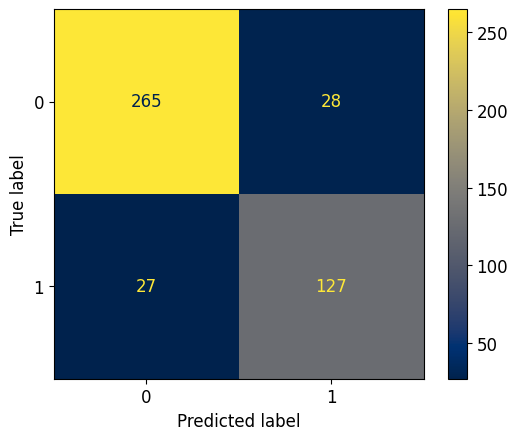

In [45]:
# Probamos el modelo con los mejores parámetros
y_pred = best_rfb.predict(X_val_processed)

# Métricas: exactitud, precisión, recall y F1-score
print(classification_report(y_val, y_pred, digits=2))

# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap = 'cividis')

En tareas de clasificación se usa el cuadrado del número total de características para considerar el número de ellas al dividir un nodo. En nuestro caso, el mejor modelo, que clasifica correctamente un ~88% de las muestras, utiliza todas las variables, `max_features=None`, en lugar de seleccionar aleatoriamente un subconjunto de ellas. Esto da como resultado un modelo que es un *bagged ensemble* ordinario de árboles de decisión, donde la aleatoriedad proviene únicamente del muestreo de datos. Esto no es necesariamente algo malo y ya obtenemos unos resultados del nivel del anterior modelo. Veamos si podemos mejorar algo ajustando el umbral.

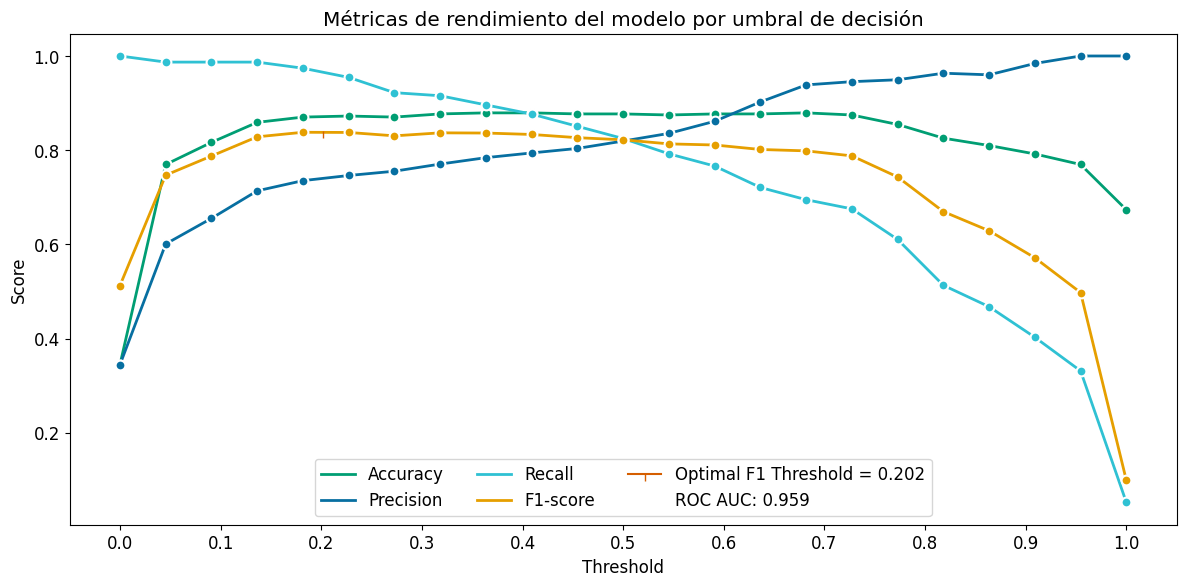

In [46]:
df_metrics, threshold_rfb = tune_and_plot_threshold(best_rfb, X_val_processed, y_val)

In [47]:
val_metrics_rfb = train_val_metrics(best_rfb, X_train_processed, y_train, X_val_processed, y_val, threshold_rfb)

Metric,Training Set,Validation Set
Accuracy,0.892000,0.872000
F1-score,0.864000,0.840000
Recall,1.000000,0.974000
Precision,0.761000,0.739000
ROC AUC,0.997000,0.959000


Hemos obtenido un modelo satisfactorio en cuanto al sobreajuste, pues tiene un rendimiento con el *set* de entrenamiento que no difiere mucho del que se obtiene con datos nuevos, y que consigue muy pocos Falsos Negativos, lo que se observa en la métrica de *recall*. El modelo captura todas las personas diagnósticadas con síndrome metabólico en el conjunto de entrenamiento, y aun rinde bien con datos nuevos, consiguiendo además una ROC AUC que muestra buena discriminación entre las clases. Es un resultado interesante para la naturaleza de nuestro problema, pero probaremos utilizando la segunda componente de aletoriedad de *random forest* (limitar `max_features`) para mejorar la *F1-score*. Si queremos reducir la complejidad de los estimadores para bajar el riesgo de *overfitting* limitaremos la profundidad de los árboles y daremos un valor mayor a `min_samples_leaf`. También tendremos que reducir el número de atributos a tener en cuenta al considerar la división y la fracción de muestras para entrenar cada árbol, `max_features`y `max_samples`.

In [48]:
# Classifier Random Forest
model_rf = RandomForestClassifier(random_state=23)

# Hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],       # function to measure the quality of a split, default gini
    'max_depth': [5, 8],                    # limit tree depth
    'min_samples_leaf': [10, 15, 20],       # minimum number of samples required to be at a leaf node, larger simpler trees
    'max_samples': [0.9, 0.92, 0.94, 0.96], # limit fraction of samples to train each tree  
    'max_features': [2, 3, 4, 6, 8, 10, 11]
}

# Creade grid search and train the model
grid_rf = GridSearchCV(model_rf, param_grid, scoring=metric, n_jobs=-1, cv=5)
%time grid_rf.fit(X_train_processed, y_train)

# Summarize
best_rf = summarize_training(grid_rf)

CPU times: user 1.72 s, sys: 227 ms, total: 1.95 s
Wall time: 18.5 s
Best Mean F1-score: 0.821
Standard Deviation: 0.021
Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 10, 'max_samples': 0.96, 'min_samples_leaf': 10}


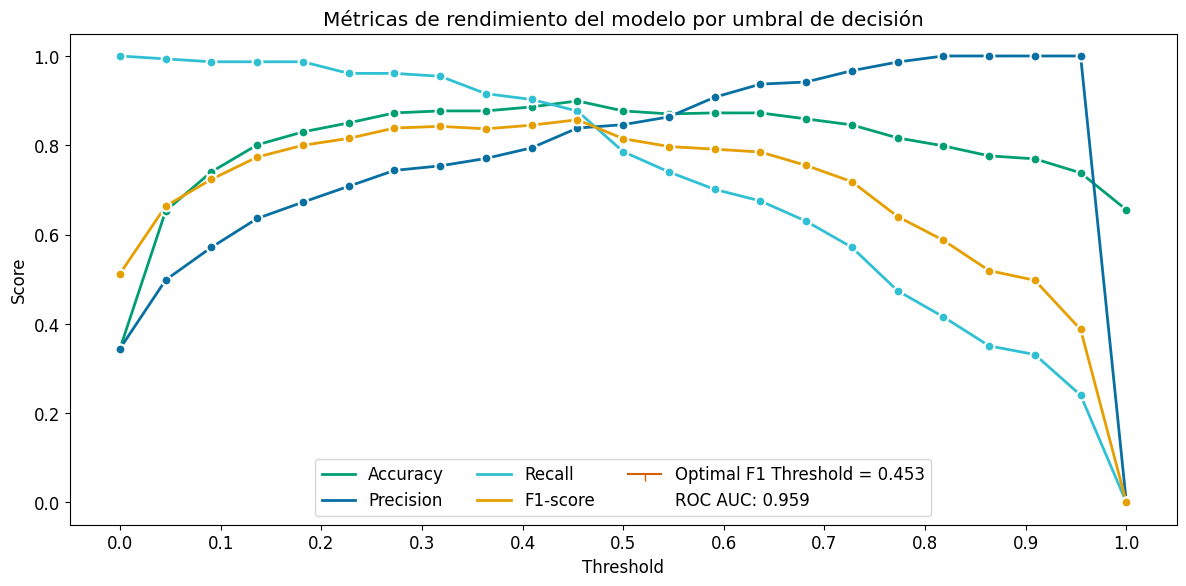

Metric,Training Set,Validation Set
Accuracy,0.925000,0.897000
F1-score,0.894000,0.854000
Recall,0.922000,0.877000
Precision,0.867000,0.833000
ROC AUC,0.985000,0.959000


In [49]:
df_metrics, threshold_rf = tune_and_plot_threshold(best_rf, X_val_processed, y_val)
val_metrics_rf = train_val_metrics(best_rf, X_train_processed, y_train, X_val_processed, y_val, threshold_rf)

Se consiguen cifras mayores en el *F1-score* y la exactitud, gracias a puntuar mejor en la precisión, pero no siendo ésta nuestra métrica más crítica y apreciando cierto sobreajuste esta vez, nos quedaremos con el anterior modelo y pasaremos entonces a probar con algoritmos de *gradient boosting*.

### Extreme Gradient Boosting (XGBoost)

*Boosting* se refiere a una familia de métodos *ensemble* en los que los estimadores se entrenan de forma secuencial, cada uno aprendiendo de los errores de su predecesor. En particular, la idea es construir nuevos árboles de manera iterativa para reducir los errores en las predicciones de la secuencia de árboles existente. XGBoost es un método de *gradient boosting*, que se basa en la idea del descenso de gradiente como optimización del *boosting*. Usaremos la [implementación de la API de scikit-learn para la clasificación XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier), donde estableceremos la tasa de aprendizaje (`eta`) con `learning_rate`, además de los hiperparámetros básicos del modelo anterior, como la profundidad de los árboles o el número de ellos. Para luchar contra el *overfitting* limitaremos fuertemente estos hiperparámetros y estableceremos `subsample` a 0,5, para tomar una muestra aleatoria de la mitad de los datos de entrenamiento antes de hacer crecer los árboles.

In [50]:
# Classifier XGBoost
model_xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=23)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 80, 100, 110],       # number of boosting rounds, default 100
    'max_depth': [3],                         # maximum tree depth for base learners, default 6
    'learning_rate': [0.04, 0.05, 0.06],      # = eta, step size shrinkage, default 0.3
    'subsample': [0.5],                       # default 1
}

# Create grid search and train the model
# n_jobs set up to None to avoid warnings
grid_xgb = GridSearchCV(model_xgb, param_grid, scoring=metric, n_jobs=None, cv=5)
%time grid_xgb.fit(X_train_processed, y_train)

# Summarize
best_xgb = summarize_training(grid_xgb)

CPU times: user 3.17 s, sys: 9 s, total: 12.2 s
Wall time: 4.18 s
Best Mean F1-score: 0.823
Standard Deviation: 0.026
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}


              precision    recall  f1-score   support

           0       0.89      0.92      0.91       293
           1       0.85      0.79      0.82       154

    accuracy                           0.88       447
   macro avg       0.87      0.86      0.86       447
weighted avg       0.88      0.88      0.88       447



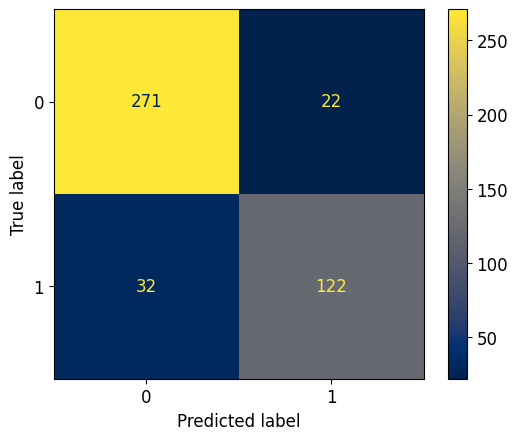

In [51]:
# Probamos el modelo con los mejores parámetros
y_pred = best_xgb.predict(X_val_processed)

# Métricas: exactitud, precisión, recall y F1-score
print(classification_report(y_val, y_pred, digits=2))

# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap = 'cividis')

El rendimiento es similar en *F1-score* al *random forest*, pero no equilibra tanto los casos clasificados incorrectamente. Veamos cuantos Falsos Negativos podemos disminuir con el ajuste del umbral:

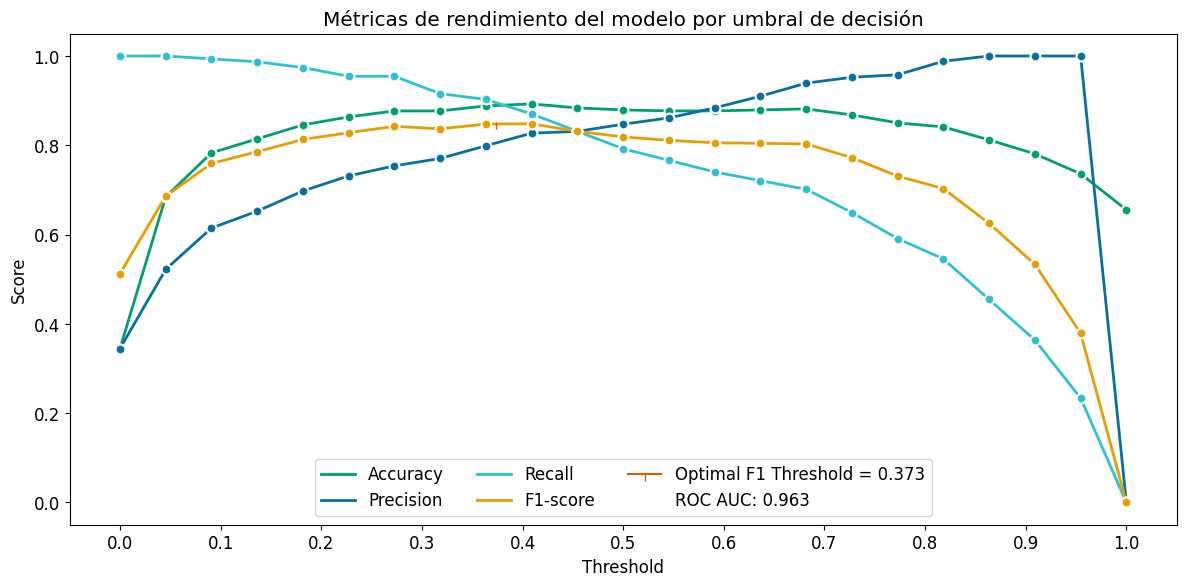

Metric,Training Set,Validation Set
Accuracy,0.922000,0.893000
F1-score,0.893000,0.852000
Recall,0.952000,0.896000
Precision,0.841000,0.812000
ROC AUC,0.982000,0.963000


In [52]:
df_metrics, threshold_xgb = tune_and_plot_threshold(best_xgb, X_val_processed, y_val)
val_metrics_xgb = train_val_metrics(best_xgb, X_train_processed, y_train, X_val_processed, y_val, threshold_xgb)

Resulta en las mejores puntaciones en el conjunto de validación sin mucho riesgo de *overfitting*. Ha sido necesario mantener la tasa de aprendizaje al valor escogido y limitar el número de árboles, para que el algoritmo no sobreajustara rápidamente. La matriz de confusión con el umbral ajustado queda como:

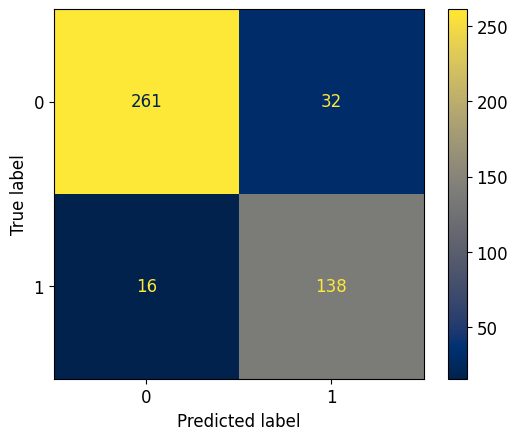

In [53]:
ConfusionMatrixDisplay.from_predictions(y_val, best_xgb.predict_proba(X_val_processed)[:,1] >= threshold_xgb, cmap = 'cividis')

### CatBoost

CatBoost es otro algoritmo basado en *gradient boosting*, que introduce el "*boosting* ordenado", dividiendo el conjunto de datos de entrenamiento en permutaciones aleatorias. Por defecto crea cuatro para evitar el *overfitting*, cuya aleatoriedad puede controlarse a través del hiperparámetro `bagging_temperature`. También limitaremos el número de árboles y probaremos con mayores regularizaciones.

In [54]:
# Clasificador CatBoost
model_cat = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_state=23, verbose=0)

# Hyperparameter grid
param_grid = {
    'iterations': [200],                   # number of boosting iterations, default 500
    'depth': [3, 5],                       # depth of the tree, default 6
    'learning_rate': [0.008, 0.009, 0.01], # step size shrinkage, default 0.03
    'l2_leaf_reg': [4, 5, 6, 8],           # L2 regularization term, default 3
    'bagging_temperature': [0]             # controls the randomness of bagging, default 1
}

# Create grid search and train the model
grid_cat = GridSearchCV(model_cat, param_grid, scoring=metric, n_jobs=None, cv=5)
%time grid_cat.fit(X_train_processed, y_train)

# Summarize
best_cat = summarize_training(grid_cat)

CPU times: user 19.5 s, sys: 35.4 s, total: 54.9 s
Wall time: 10.7 s
Best Mean F1-score: 0.830
Standard Deviation: 0.025
Best Parameters: {'bagging_temperature': 0, 'depth': 5, 'iterations': 200, 'l2_leaf_reg': 4, 'learning_rate': 0.01}


              precision    recall  f1-score   support

           0       0.89      0.94      0.92       293
           1       0.88      0.79      0.83       154

    accuracy                           0.89       447
   macro avg       0.89      0.86      0.87       447
weighted avg       0.89      0.89      0.89       447



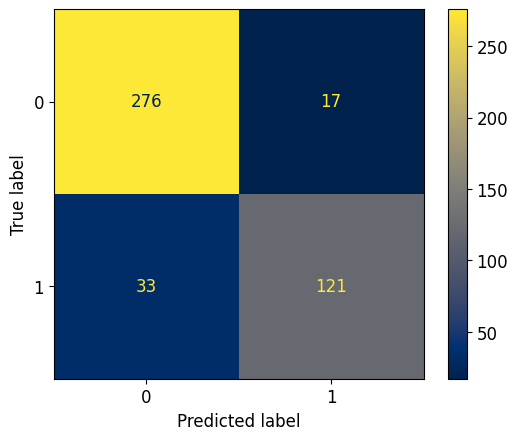

In [55]:
# Probamos el modelo con los mejores parámetros
y_pred = best_cat.predict(X_val_processed)

# Métricas: exactitud, precisión, recall y F1-score
print(classification_report(y_val, y_pred, digits=2))

# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap = 'cividis')

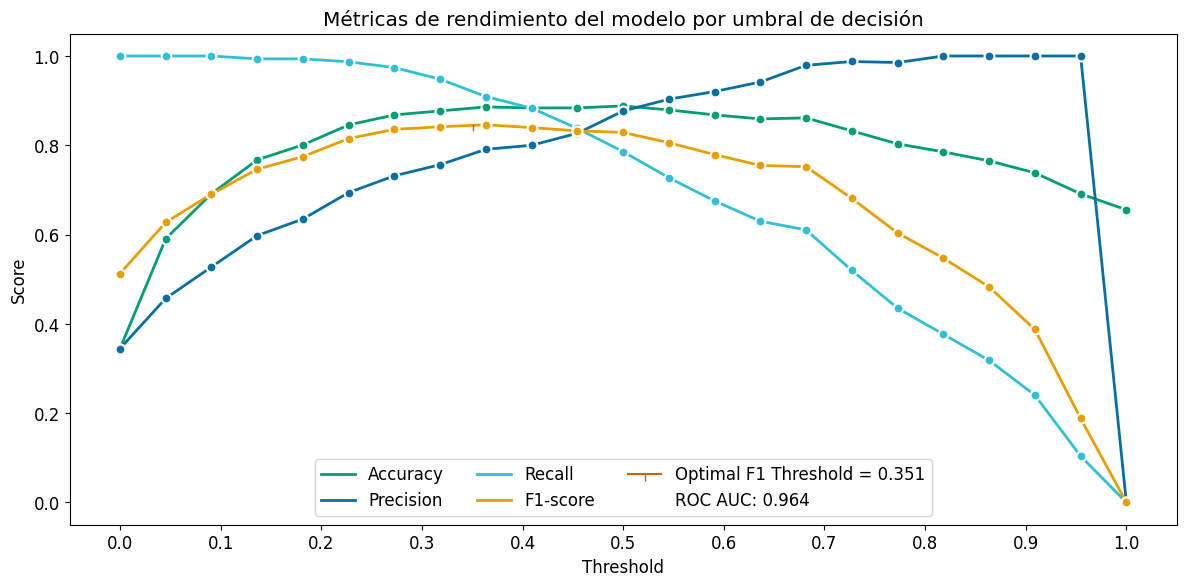

In [56]:
df_metrics, threshold_cat = tune_and_plot_threshold(best_cat, X_val_processed, y_val)

In [57]:
val_metrics_cat = train_val_metrics(best_cat, X_train_processed, y_train, X_val_processed, y_val, threshold_cat)

Metric,Training Set,Validation Set
Accuracy,0.901000,0.886000
F1-score,0.869000,0.848000
Recall,0.959000,0.922000
Precision,0.795000,0.785000
ROC AUC,0.977000,0.964000


Con unas métricas similares al modelo anterior, aunque si buscamos aumentarlas para el conjunto de validación, disparemos rápidamente las distancias entre los valores de los *sets*.

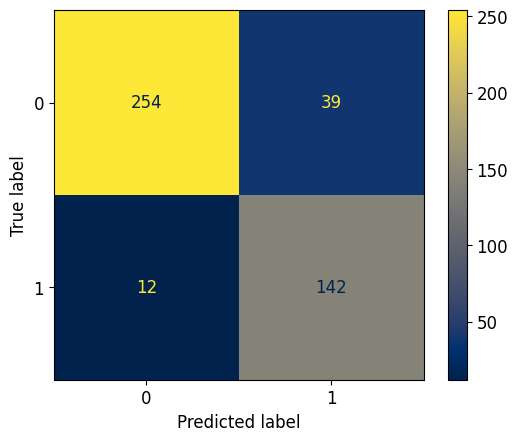

In [58]:
# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, best_cat.predict_proba(X_val_processed)[:,1] >= threshold_cat, cmap = 'cividis')

### Light Gradient-Boosting Machine (LigthGBM)

Para finalizar con modelos de *gradient boosting* basados en árboles, [usaremos LightGBM](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier), originalmente desarrollado por Microsoft y que difiere de las técnicas anteriores principalmente en la forma en que crece los árboles y en el algoritmo para la división, basado en histogramas, agrupando los valores numéricos de los atributos en *bins* discretos. Es un *framework* con un centenar de hiperparámetros, pero centraremos los esfuerzos en evitar *overfitting* a la hora de decidirnos por aquellos a combinar. Los principales hiperparámetros para controlar la complejidad de los árboles son `num_leaves`, del que tendremos en cuenta valores menores de 2^`max_depth` y `min_child_samples` con un valor grande para evitar árboles demasiado profundos. También usaremos regularización para reducir la complejidad del modelo a través de los parámetros `reg_alpha`, `reg_lambda` y `min_split_gain`. Forzaremos *bagging* con `bagging_fraction` < 1 y `bagging_freq`> 0. Por último, `max_bin` permite establecer el número máximo de grupos a discretizar, del que usaremos un valor más pequeño del de por defecto.

In [59]:
# Clasificador LightGBM
model_lgbm = LGBMClassifier(objective='binary', boosting_type='gbdt', random_state=23, verbose=-1)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100],           # number of boosted trees to fit, default 100
    'max_depth': [4, 5, 6, 8, 10],   # maximum tree depth for base learners, default -1, no limit
    'num_leaves': [5, 8, 10, 16],    # maximum tree leaves for base learners, default 31
    'learning_rate': [0.1],          # boosting learning rate, default 0.1
    'min_child_samples': [200],      # minimum number of data needed in a child (leaf), default 20
    'reg_alpha': [0.1],              # L1 regularization term, default 0
    'reg_lambda': [0.1],             # L2 regularization term, default 0         
    'min_split_gain': [0.1],         # minimum loss reduction for partition, default 0
    'bagging_fraction': [0.8],       # bagging is only effective when 0 < bagging_fraction < 1, default 1
    'bagging_freq': [1],             # frequency for bagging, default 0
    'max_bin': [150]                 # max number of bins that feature values will be bucketed in, default 255
}

# Create grid search and train the model
grid_lgbm = GridSearchCV(model_lgbm, param_grid, scoring=metric, n_jobs=None, cv=5)
%time grid_lgbm.fit(X_train_processed, y_train)

# Summarize
best_lgbm = summarize_training(grid_lgbm)

CPU times: user 2.88 s, sys: 11.6 s, total: 14.5 s
Wall time: 4.78 s
Best Mean F1-score: 0.837
Standard Deviation: 0.029
Best Parameters: {'bagging_fraction': 0.8, 'bagging_freq': 1, 'learning_rate': 0.1, 'max_bin': 150, 'max_depth': 4, 'min_child_samples': 200, 'min_split_gain': 0.1, 'n_estimators': 100, 'num_leaves': 5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}


              precision    recall  f1-score   support

           0       0.90      0.93      0.92       293
           1       0.86      0.81      0.84       154

    accuracy                           0.89       447
   macro avg       0.88      0.87      0.88       447
weighted avg       0.89      0.89      0.89       447



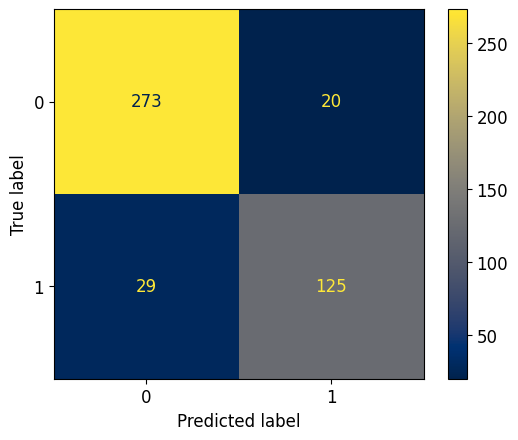

In [60]:
# Probamos el modelo con los mejores parámetros
y_pred = best_lgbm.predict(X_val_processed)

# Métricas: exactitud, precisión, recall y F1-score
print(classification_report(y_val, y_pred, digits=2))

# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, y_pred, cmap = 'cividis')

De momento obtenemos unas métricas similares al desempeño habitual que estamos obteniedo con estos modelos.

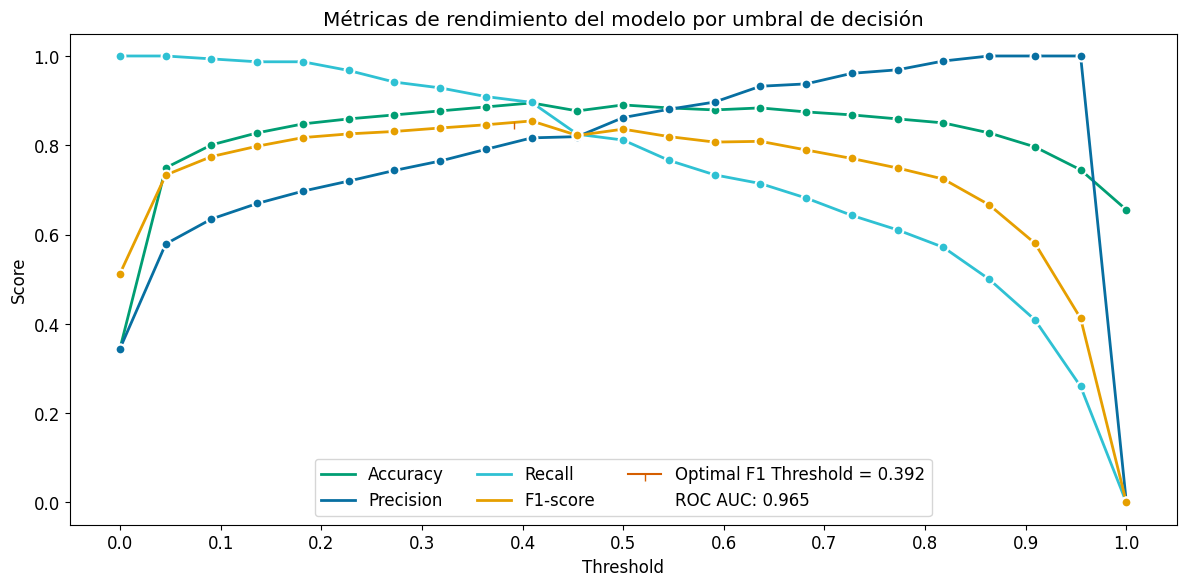

In [61]:
df_metrics, threshold_lgbm = tune_and_plot_threshold(best_lgbm, X_val_processed, y_val)

Metric,Training Set,Validation Set
Accuracy,0.907000,0.893000
F1-score,0.874000,0.853000
Recall,0.937000,0.903000
Precision,0.818000,0.808000
ROC AUC,0.976000,0.965000


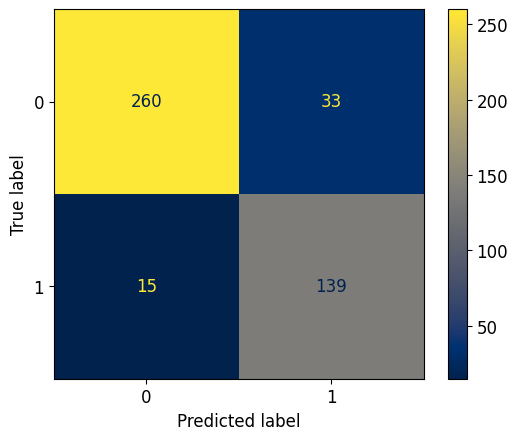

In [62]:
val_metrics_lgbm = train_val_metrics(best_lgbm, X_train_processed, y_train, X_val_processed, y_val, threshold_lgbm)
# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_val, best_lgbm.predict_proba(X_val_processed)[:,1] >= threshold_lgbm, cmap = 'cividis')

El ajuste exhaustivo de los hiperparámetros era necesario, ya que este modelo se sobreajusta con nuestros datos con gran facilidad, como podemos ver si eliminamos las restricciones:

In [63]:
# Clasificador LightGBM con sobreajuste
model_lgbm_overfit = LGBMClassifier(objective='binary', boosting_type='gbdt', random_state=23, verbose=-1)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 500]     # number of boosted trees to fit, default 100
}

# Create grid search and train the model
grid_lgbm_overfit = GridSearchCV(model_lgbm_overfit, param_grid, scoring=metric, n_jobs=None, cv=5)
%time grid_lgbm_overfit.fit(X_train_processed, y_train)

# Summarize
best_lgbm_overfit = summarize_training(grid_lgbm_overfit)
val_metrics_lgbm_overfit = train_val_metrics(best_lgbm_overfit, X_train_processed, y_train, X_val_processed, y_val, 0.5)

CPU times: user 6.6 s, sys: 31.2 s, total: 37.8 s
Wall time: 11.7 s
Best Mean F1-score: 0.849
Standard Deviation: 0.027
Best Parameters: {'n_estimators': 100}


Metric,Training Set,Validation Set
Accuracy,1.000000,0.875000
F1-score,1.000000,0.813000
Recall,1.000000,0.792000
Precision,1.000000,0.836000
ROC AUC,1.000000,0.960000


## Comparación de modelos

Vamos a resumir las métricas de todos los modelos que hemos probado, para el conjunto de validación:

In [64]:
# Combinamos las métricas de cada modelo en un dataframe
summary_lr = pd.DataFrame(val_metrics_lr['Validation Set'].values, index=val_metrics_lr['Metric'], columns=['Logistic Regression']).rename_axis(None)
summary_dt = pd.DataFrame(val_metrics_dt['Validation Set'].values, index=val_metrics_dt['Metric'], columns=['Decision Tree']).rename_axis(None)
summary_rf = pd.DataFrame(val_metrics_rfb['Validation Set'].values, index=val_metrics_rfb['Metric'], columns=['Random Forest']).rename_axis(None)
# summary_rf = pd.DataFrame(val_metrics_rf['Validation Set'].values, index=val_metrics_rf['Metric'], columns=['Random Forest']).rename_axis(None)
summary_xgb = pd.DataFrame(val_metrics_xgb['Validation Set'].values, index=val_metrics_xgb['Metric'], columns=['XGBoost']).rename_axis(None)
summary_cat = pd.DataFrame(val_metrics_cat['Validation Set'].values, index=val_metrics_cat['Metric'], columns=['CatBoost']).rename_axis(None)
summary_lgbm = pd.DataFrame(val_metrics_lgbm['Validation Set'].values, index=val_metrics_lgbm['Metric'], columns=['LightGBM']).rename_axis(None)


metrics_val_all = pd.concat([summary_lr, summary_dt, summary_rf, summary_xgb, summary_cat, summary_lgbm], axis=1)
display(metrics_val_all)

,Logistic Regression,Decision Tree,Random Forest,XGBoost,CatBoost,LightGBM
Accuracy,0.830,0.890,0.872,0.893,0.886,0.893
F1-score,0.783,0.850,0.840,0.852,0.848,0.853
Recall,0.890,0.903,0.974,0.896,0.922,0.903
Precision,0.699,0.803,0.739,0.812,0.785,0.808
ROC AUC,0.920,0.927,0.959,0.963,0.964,0.965


LightGBM obtiene el mejor valor en *F1-score*, pero no en *recall*, que son las dos métricas a las que queremos prestar más atención. En esta última, el *random forest* sale ganador, aunque LightGBM obtiene también la mejor puntuación en *ROC AUC*. No es obvio por cuál de los *ensemble* decidirse.

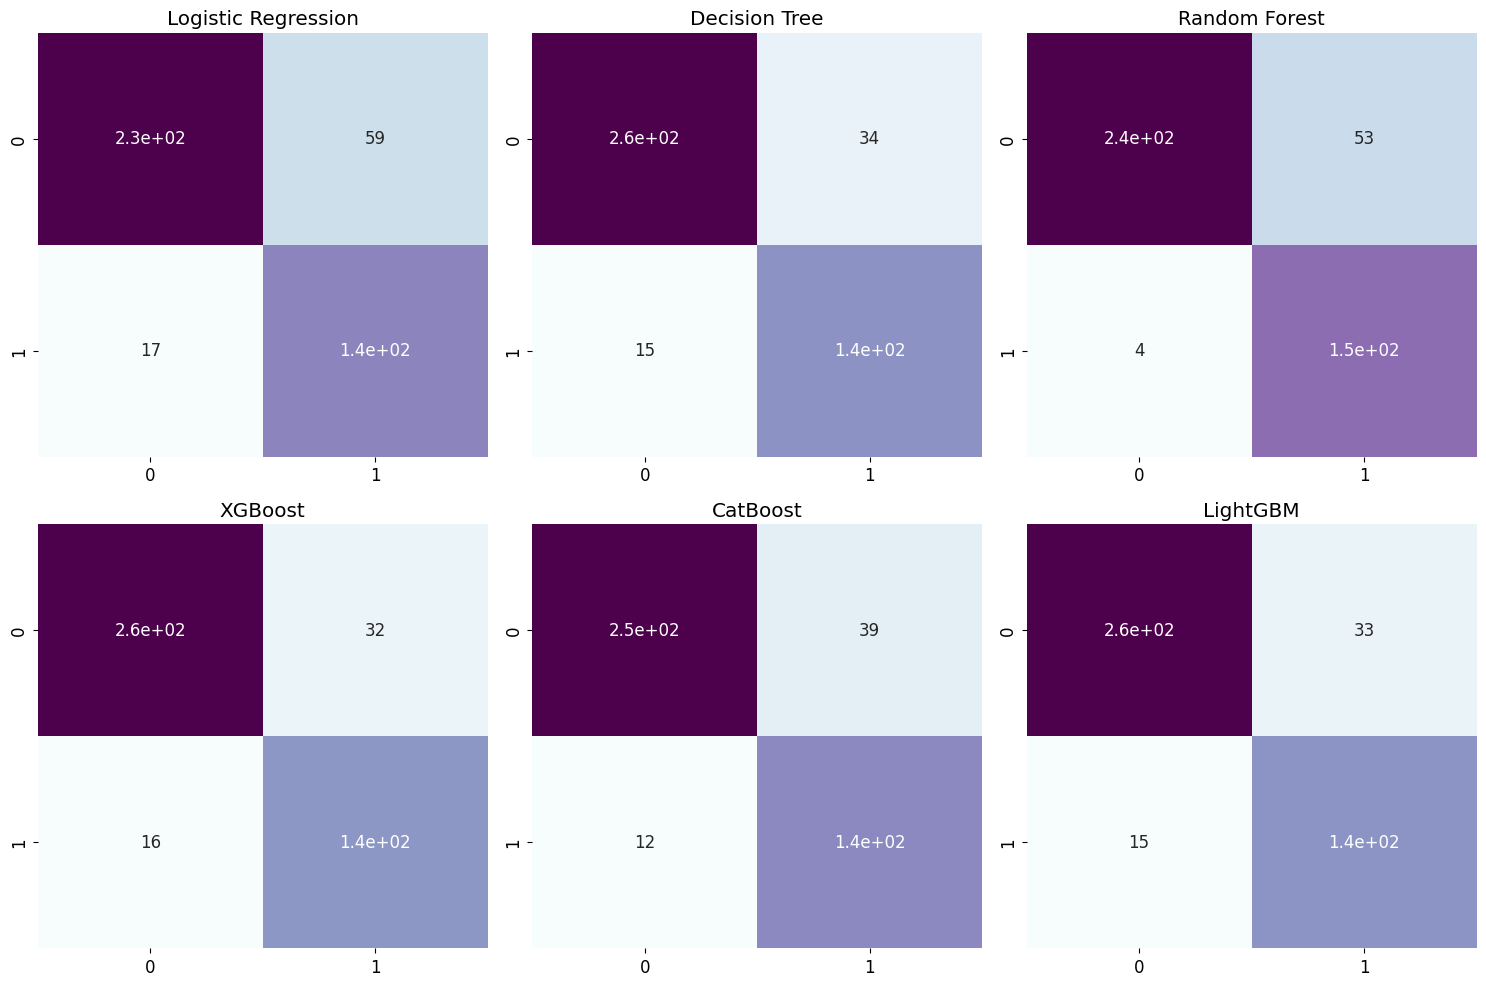

In [65]:
# Combinamos las matrices de confusión para seis modelos tuneados
cm_lr = confusion_matrix(y_val, best_lr.predict_proba(X_val_processed_norm)[:,1] >= threshold_lr)
cm_dt = confusion_matrix(y_val, best_dt.predict_proba(X_val_processed)[:,1] >= threshold_dt)
cm_rf = confusion_matrix(y_val, best_rfb.predict_proba(X_val_processed)[:,1] >= threshold_rfb)
cm_xgb = confusion_matrix(y_val, best_xgb.predict_proba(X_val_processed)[:,1] >= threshold_xgb)
cm_cat = confusion_matrix(y_val, best_cat.predict_proba(X_val_processed)[:,1] >= threshold_cat)
cm_lgbm = confusion_matrix(y_val, best_lgbm.predict_proba(X_val_processed)[:,1] >= threshold_lgbm)

# Visualizamos
figure, axes = plt.subplots(2,3, figsize=(15,10))

sns.heatmap(cm_lr, annot=True, cmap='BuPu', cbar=False, ax=axes[0,0])
axes[0,0].set_title('Logistic Regression')
sns.heatmap(cm_dt, annot=True, cmap='BuPu', cbar=False, ax=axes[0,1])
axes[0,1].set_title('Decision Tree')
sns.heatmap(cm_rf, annot=True, cmap='BuPu', cbar=False, ax=axes[0,2])
axes[0,2].set_title('Random Forest', fontsize=14)
sns.heatmap(cm_xgb, annot=True, cmap='BuPu', cbar=False, ax=axes[1,0])
axes[1,0].set_title('XGBoost')
sns.heatmap(cm_cat, annot=True, cmap='BuPu', cbar=False, ax=axes[1,1])
axes[1,1].set_title('CatBoost')
sns.heatmap(cm_lgbm, annot=True, cmap='BuPu', cbar=False, ax=axes[1,2])
axes[1,2].set_title('LightGBM')

plt.tight_layout(pad=1)
plt.show()

Los resultados tan similares de las matrices de confusión tampoco ayudan mucho, podríamos considerar que se consigue un resultado robusto con LightGBM, que además obtiene una ligera mayor puntuación en el conjunto de métricas si las comparamos con el resto de modelos. Sin embargo, tenemos un *random forest* que consigue bastantes menos Falsos Negativos que el resto de modelos, y siendo esto de vital importancia en nuestro contexto médico, hace que nos decantemos por el bosque aleatorio como el clasificador seleccionado para la predicción del diagnóstico de síndrome metabólico.

### Prueba del modelo

Estamos ahora en disposición de alimentar el modelo seleccionado con el conjunto de prueba. Lo entrenaremos primero con el *set train_full*.

In [66]:
# Entrenamos el modelo con los mejores hiperparámetros
model = best_rfb.fit(X_train_full_processed, y_train_full)

y_pred = model.predict_proba(X_test_processed)[:, 1]

# Calculamos las métricas para el set de prueba
metrics = {
        'Metric': ['Accuracy', 'F1-score', 'Recall', 'Precision', 'ROC AUC'],
        'Test Set': [
            accuracy_score(y_test, y_pred >= threshold_rfb), 
            f1_score(y_test, y_pred >= threshold_rfb),
            recall_score(y_test, y_pred >= threshold_rfb),
            precision_score(y_test, y_pred >= threshold_rfb, zero_division=0),
            roc_auc_score(y_test, y_pred)
        ]
    }    

# Mostramos tabla con los valores de las métricas
test_metrics = pd.DataFrame(metrics).round(3)
display(test_metrics.style.hide(axis="index"))

Metric,Test Set
Accuracy,0.849000
F1-score,0.816000
Recall,0.976000
Precision,0.702000
ROC AUC,0.945000


Unos valores similares a los que acabamos de resumir cuando aplicamos el modelo sobre los conjuntos de entrenamiento y validación, con lo que esperamos que estará generalizando bien.

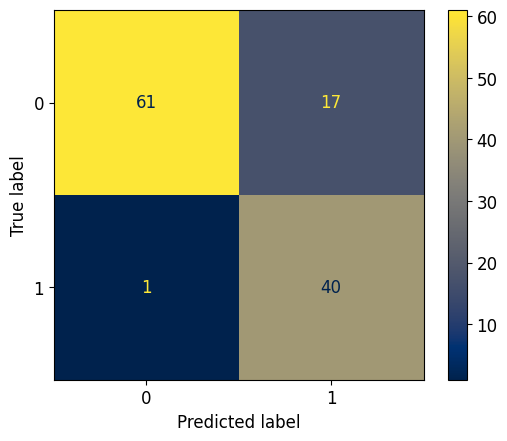

In [67]:
# Mostramos la matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, best_rfb.predict_proba(X_test_processed)[:,1] >= threshold_rfb, cmap = 'cividis')

Obtuvimos solamente 1 Falso Negativo con *random forest* sobre el conjunto de prueba, que viene a corresponderse con los porcentajes de los resultados vistos anteriormente con los conjuntos de validación:

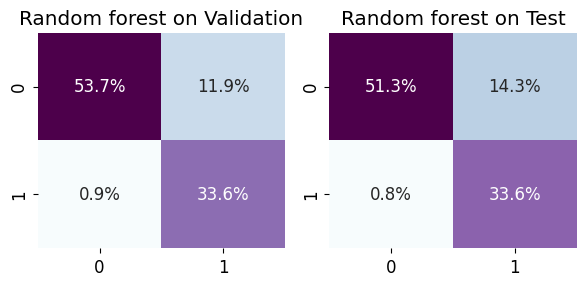

In [68]:
# Matrices de confusión en porcentages para los conjuntos de validación y prueba
cm_rf_test = confusion_matrix(y_test, best_rfb.predict_proba(X_test_processed)[:,1] >= threshold_rfb)

# Visualizamos
figure, axes = plt.subplots(1, 2, figsize=(6,3))

sns.heatmap(cm_rf/np.sum(cm_rf), annot=True, fmt='.1%', cmap='BuPu', cbar=False, ax=axes[0])
axes[0].set_title('Random forest on Validation')
sns.heatmap(cm_rf_test/np.sum(cm_rf_test), annot=True, fmt='.1%', cmap='BuPu', cbar=False, ax=axes[1])
axes[1].set_title('Random forest on Test')

plt.tight_layout(pad=1)
plt.show()

# Conclusión

Partiendo de un modelo lineal inicial, la regresión logística, con un desempeño razonable pero limitado para capturar relaciones más complejas en los datos, se emplearon métodos basados en árboles para mejorar la tarea de clasificación emprendida. Con base a métricas de rendimiento, estos modelos obtuvieron los mejores resultados posibles en cuanto a exactitud y *F1-score*, en el límite del 85% de media para ésta y del 89% para la *accuracy*. Para poder decantarnos por uno de entre estos modelos –Decision Tree, Random Forest, XGBoost, CatBoost y LightGBM–, prestamos entonces atención a métricas como la ROC AUC y *recall*. El interés por minimizar el número de Falsos Negativos consiguiendo a su vez un resultado robusto en discriminación de casos, sitúa al bosque aleatorio como candidato sólido para la tarea de clasificación del diagnóstico de síndrome metabólico.

Examinemos una vez más la naturaleza de este problema a la hora de evaluar el uso de estos modelos. Consideramos crucial que individuos con síndrome metabólico no se clasifiquen como sanos, esto es, que el número de Falsos Negativos sea mínimo (*recall* lo más cercana a 1 posible). La primera línea de tratamiento del síndrome metabólico son cambios cardiosaludables en el estilo de vida, con medicación solo en casos de ciertos marcadores anormales. En esta situación, no le haría ningún daño cuidar la dieta, hacer más ejercicio o dejar de fumar a una persona sana (errar en la clase negativa), pero puede resultar peligroso no tratar a una enferma (errar en la clase positiva). Por ejemplo, en nuestro análisis, con el bosque aleatorio tendríamos una persona que correría riesgo por no ser tratada, mientras que con las *gradient boosting machines* tendríamos 4, aunque produzcan menos Falsos Positivos.

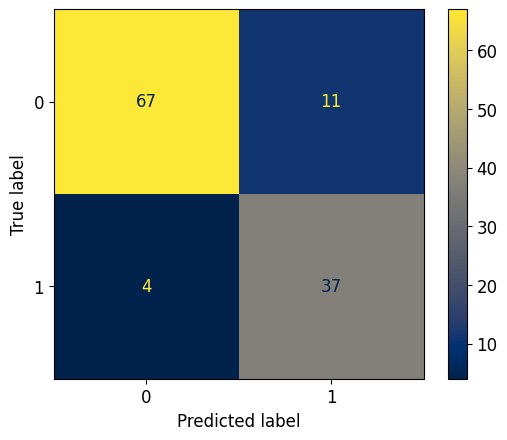

In [69]:
# Entrenamos el modelo LightGBM con los mejores hiperparámetros
best_lgbm.fit(X_train_full_processed, y_train_full)
# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, best_lgbm.predict_proba(X_test_processed)[:,1] >= threshold_lgbm, cmap = 'cividis')

En la consecución de estas métricas, todos los modelos siguieron un proceso continuo de ajuste de hiperparámetros y umbrales de decisión. Además de un cuidadoso preprocesamiento de los datos, incluyendo imputación de valores ausentes y estandarización de características. La elección de otros tipos de normalizaciones, como `MinMaxScaler()` y `RobustScaler()`, o transformaciones, como `PowerTransformer()`, no mejoraron la capacidad predictiva de los modelos de regresión logística. Los datos se dividieron en conjuntos de entrenamiento, validación, calibración y prueba para garantizar evaluaciones consistentes y evitar sesgos, con un preprocesamiento individual de la información en cada *set*.

A pesar de suprimir un par de variables, que observamos que no añadían más que información redundante al *dataset*, es posible que una selección de características adicional hubiera sido un paso importante en la refinación de los modelos. Hay ciertos atributos que no mostraron asociaciones estadísticamente significativas y que podrían excluirse de los modelos sin comprometer la precisión predictiva. Sin embargo, creímos oportuno no hacerlo para poder explorarlos en cuadernos sucesivos, como haremos con la *feature importance*. Aunque de esta manera podemos haber omitido la ayuda que ofrece una selección de características en el mayor problema encontrado durante el entrenamiento de modelos: el *overfitting*.

En general, para el conjunto de datos de nuestro caso, los árboles de decisión y todos los modelos se *ensemble* mostraron limitaciones al sobreajustarse fácilmente. Hubo que ajustar los hiperparámetros para restringir cuidadosamente la complejidad de los árboles y los conjuntos, tanto con `n_estimator` / `iterations` menores, como con `max_depth` / `depth` o `num_leaves`. También reducir la tasa de aprendizaje (`learning_rate`) o activar regularización y *bagging* cuando fuera posible, a parte de algunos hiperparámetros propios de las diferentes *gradient boosting machines*.

Por último, los *ensemble*, aunque populares, son opacos y difíciles de interpretar, lo que resulta problemático en un contexto médico donde la transparencia es crucial. Para mitigar esta limitación y proporcionar mayor claridad sobre las decisiones del modelo, aplicaremos métodos de explicabilidad (XAI) en el siguiente cuaderno.

## Gráficos y tests extra para incluir en la memoria

In [70]:
# Generamos un gráfico para poder incluir en la memoria para mostrar los efectos de la prepoda en el overfitting

# Hiperparámetro depth
depth = range(1, 15)
train_scores_depth = []
test_scores_depth = []

for d in depth:
    tree = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_state=23, verbose=0, depth=d)
    tree.fit(X_train_full_processed, y_train_full)
    train_scores_depth.append(tree.score(X_train_full_processed, y_train_full))
    test_scores_depth.append(tree.score(X_test_processed, y_test))

# Hiperparámetro learning_rate
learning_rate = np.arange(0.001, 0.02, 0.001)
train_scores_eta = []
test_scores_eta = []

for eta in learning_rate:
    tree = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_state=23, verbose=0, learning_rate=eta)
    tree.fit(X_train_full_processed, y_train_full)
    train_scores_eta.append(tree.score(X_train_full_processed, y_train_full))
    test_scores_eta.append(tree.score(X_test_processed, y_test))

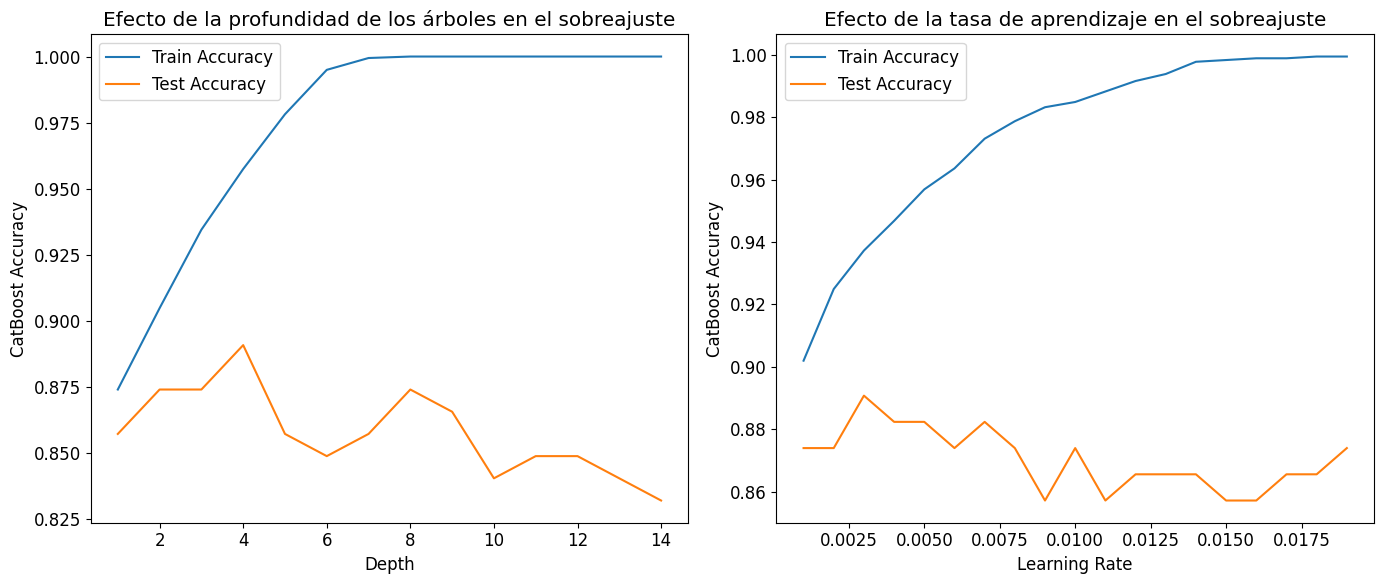

In [71]:
# Visualizamos
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Izquierda: depth
axes[0].plot(depth, train_scores_depth, label='Train Accuracy')
axes[0].plot(depth, test_scores_depth, label='Test Accuracy')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('CatBoost Accuracy')
axes[0].set_title('Efecto de la profundidad de los árboles en el sobreajuste')
axes[0].legend()

# Derecha: learning_rate
axes[1].plot(learning_rate, train_scores_eta, label='Train Accuracy')
axes[1].plot(learning_rate, test_scores_eta, label='Test Accuracy')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('CatBoost Accuracy')
axes[1].set_title('Efecto de la tasa de aprendizaje en el sobreajuste')
axes[1].legend()

plt.tight_layout()
plt.show()

In [72]:
# Test de como la selección de características previene overfitting en Random Forest
# Primero obtenemos un modelo sobreajustado

# Mismas condiciones para un random forest que sobreajustaba
model_rf_overfit = RandomForestClassifier(random_state=23)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],        # number of trees in the forest, default 100
    'criterion': ['gini', 'entropy'],       # function to measure the quality of a split, default gini
    'max_depth': [5, 8, 10, 15, 20, 30],    # default none
    'min_samples_split': [2, 5, 10],        # default 2
    'min_samples_leaf': [5, 8, 10],         # default 1
    'max_features': ['sqrt', 'log2', None]  # default sqrt
}

# Creade grid search and train the model
grid_rf = GridSearchCV(model_rf_overfit, param_grid, scoring=metric, n_jobs=-1, cv=5)
%time grid_rf.fit(X_train_processed, y_train)

# Summarize
best_rf_overfit = summarize_training(grid_rf)
val_metrics_rf_overfit = train_val_metrics(best_rf_overfit, X_train_processed, y_train, X_val_processed, y_val, 0.5)

CPU times: user 6.69 s, sys: 1.12 s, total: 7.82 s
Wall time: 2min 18s
Best Mean F1-score: 0.834
Standard Deviation: 0.018
Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}


Metric,Training Set,Validation Set
Accuracy,0.976000,0.877000
F1-score,0.965000,0.822000
Recall,0.954000,0.825000
Precision,0.976000,0.819000
ROC AUC,0.997000,0.959000


In [73]:
# Ahora con las mismas condiciones aplicamos selección de características

feature_selection = ["BloodGlucose", "HDL", "Triglycerides", "WaistCirc"]
%time grid_rf.fit(X_train_processed[feature_selection], y_train)

# Summarize
best_rf_overfit = summarize_training(grid_rf)
val_metrics_rf_overfit = train_val_metrics(best_rf_overfit, X_train_processed[feature_selection], y_train, X_val_processed[feature_selection], y_val, 0.5)

CPU times: user 3.62 s, sys: 606 ms, total: 4.23 s
Wall time: 1min 50s
Best Mean F1-score: 0.792
Standard Deviation: 0.022
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100}


Metric,Training Set,Validation Set
Accuracy,0.877000,0.864000
F1-score,0.818000,0.796000
Recall,0.807000,0.773000
Precision,0.830000,0.821000
ROC AUC,0.957000,0.939000
